In [1]:
import os
import sys
sys.path.append("../")

import math
import random
from scipy import special
import numpy as np
import torch
# import tensorflow as tf
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from utilities.compare_performance import compare_performance
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
from sympy import *
import sympy as sp
#import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad

mu = 0.05
dim = 1 
m=2
    
def exact_example(t, x, T):
    xi = (1+sum(x))/2
    return 2*np.pi*mu*np.exp(-np.pi**2*mu*dim*(T-t))*np.sin(np.pi*xi)/(m+np.exp(-np.pi**2*mu*dim*(T-t))*np.cos(np.pi*xi))


In [3]:
exact_example(0, [0.3], 0.05)

0.17539033643944893

In [4]:
nu=mu*4

def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return -2*y[0]*y[1:(dim+1)].sum(dim=0) 
  
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -2*y[0]*y[1:(dim+1)].sum(dim=0) + nu*y[(dim+1):(2*dim+1)].sum(dim=0)

def phi_example(x, coordinate=0):
    return 2*mu*torch.pi*torch.sin(torch.pi*(1+x.sum(axis=0))/2)/(m+torch.cos(torch.pi*(1+x.sum(axis=0))/2))

# def exact_example(t, x, T):
#    xi = T-t + x.sum(axis=0)
#    return np.sin(np.pi*(1+xi)/2)

def boundary_fun(x, coordinate=0):
    return torch.tensor(np.zeros(x.size()[1]), device=device).to(torch.float32)

t_lo, x_lo, x_hi = 0., -1, 1
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

In [5]:
# Conditional probability to survive
# Set boundary of DB and BSDE methods
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-1,
    upper_bound=1,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=x_lo, upper_bound=x_hi):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

## dim = 1

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 1.071120262145996 seconds.
Patch  0: epoch    0 with loss 1.88E+00


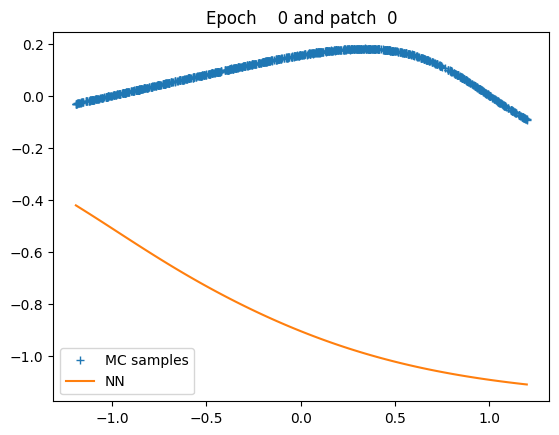

Patch  0: epoch  500 with loss 3.00E-06


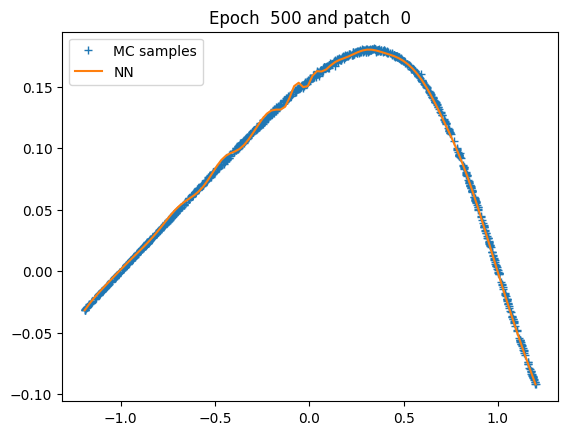

Patch  0: epoch 1000 with loss 1.54E-06


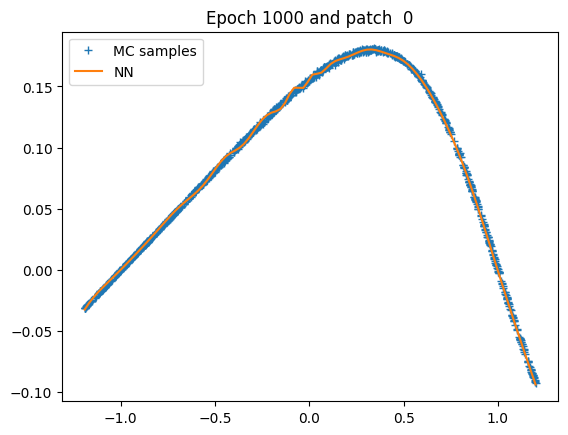

Patch  0: epoch 1500 with loss 1.34E-06


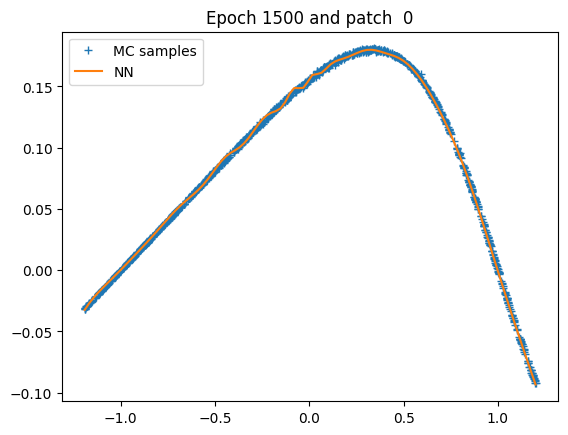

Patch  0: epoch 2000 with loss 1.14E-06


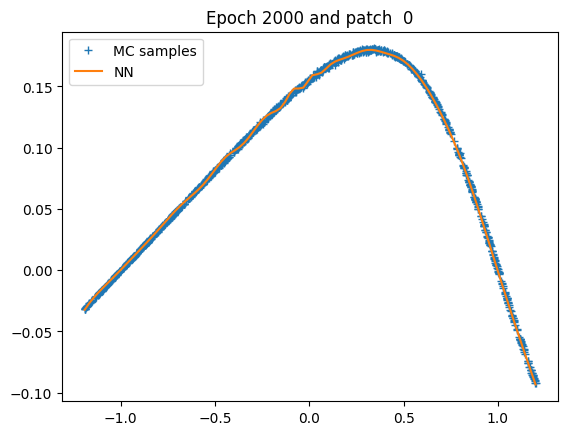

Patch  0: epoch 2499 with loss 1.12E-06


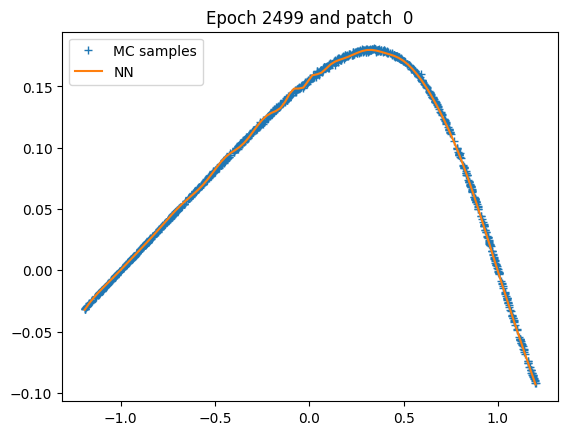

Patch 0: training of u with 2500 epochs take 18.26306915283203 seconds.


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 1: generation of u samples take 4.989801645278931 seconds.
Patch  1: epoch    0 with loss 1.69E+00


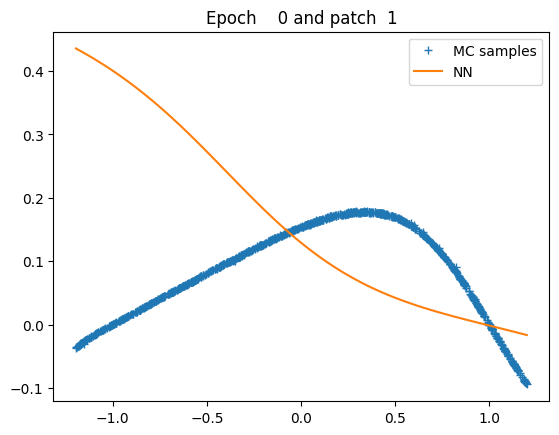

Patch  1: epoch  500 with loss 3.23E-06


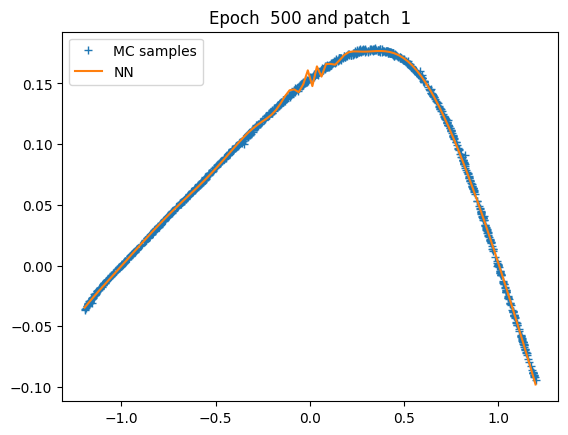

Patch  1: epoch 1000 with loss 1.76E-06


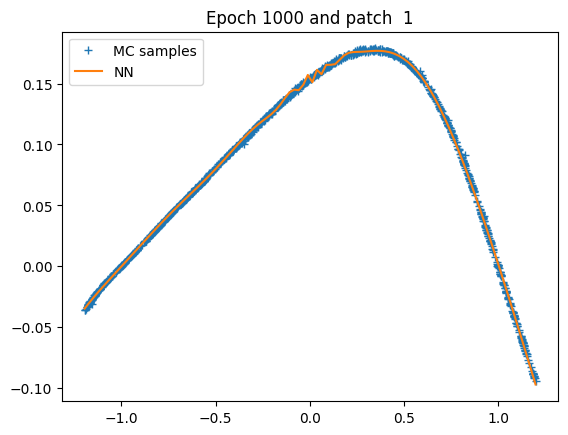

Patch  1: epoch 1500 with loss 1.63E-06


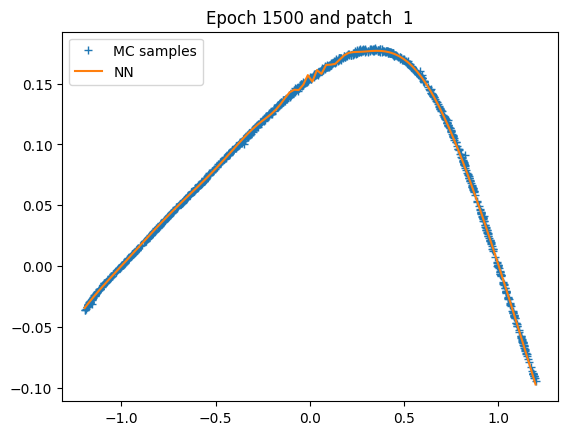

Patch  1: epoch 2000 with loss 1.48E-06


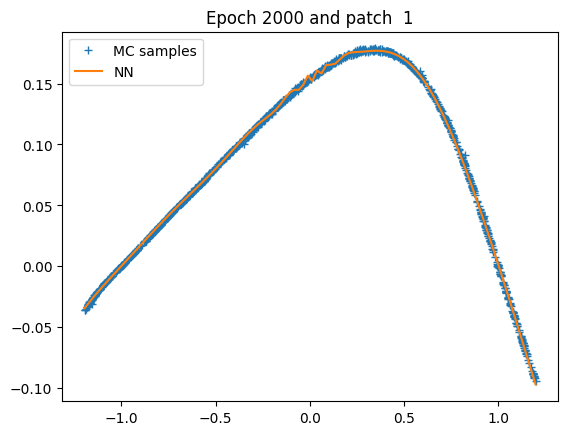

Patch  1: epoch 2499 with loss 1.46E-06


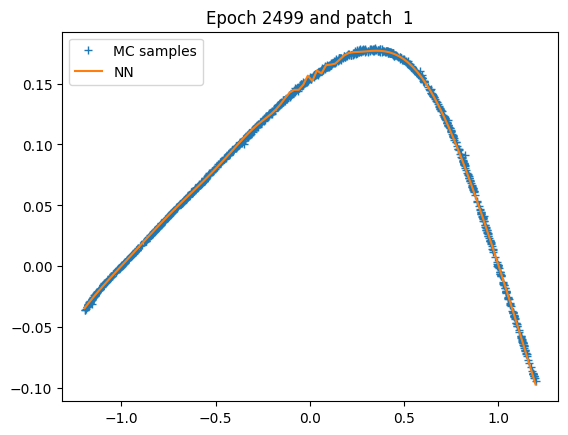

Patch 1: training of u with 2500 epochs take 19.813037395477295 seconds.


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 2: generation of u samples take 4.041820287704468 seconds.
Patch  2: epoch    0 with loss 9.75E-01


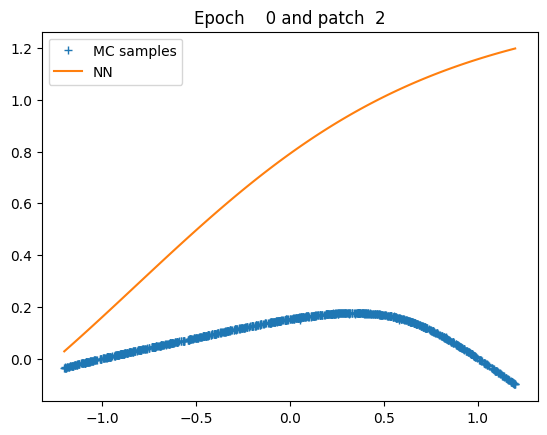

Patch  2: epoch  500 with loss 3.50E-06


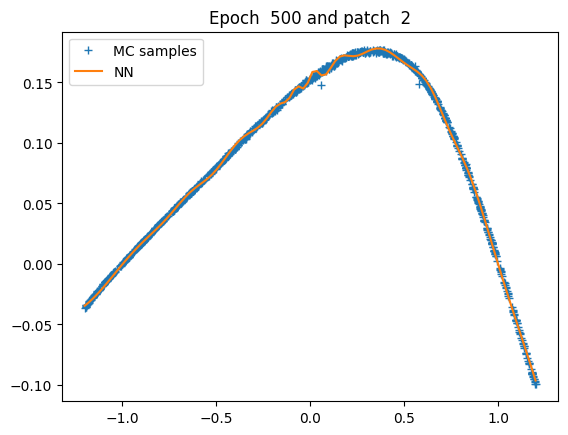

Patch  2: epoch 1000 with loss 4.95E-05


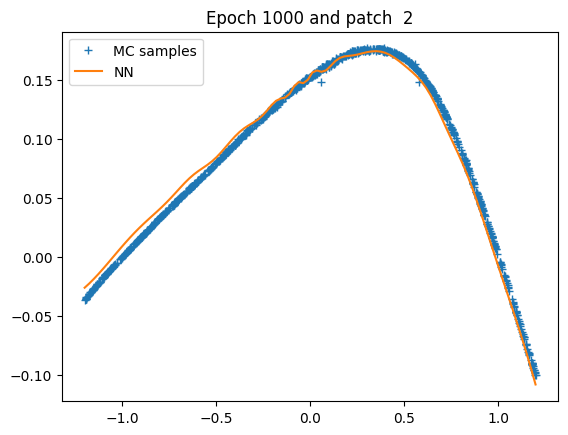

Patch  2: epoch 1500 with loss 1.51E-06


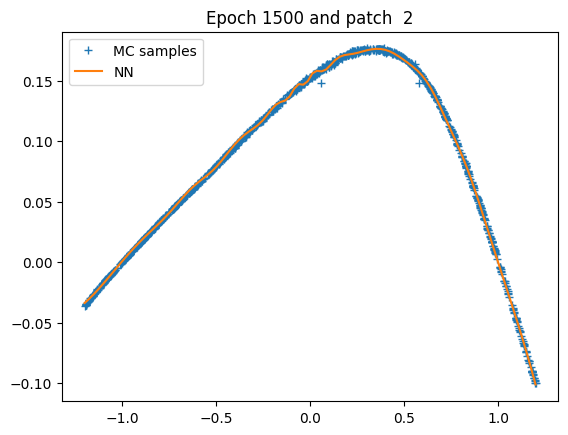

Patch  2: epoch 2000 with loss 1.39E-06


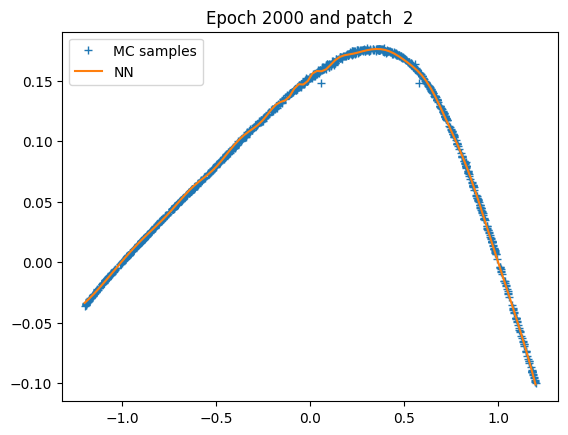

Patch  2: epoch 2499 with loss 1.38E-06


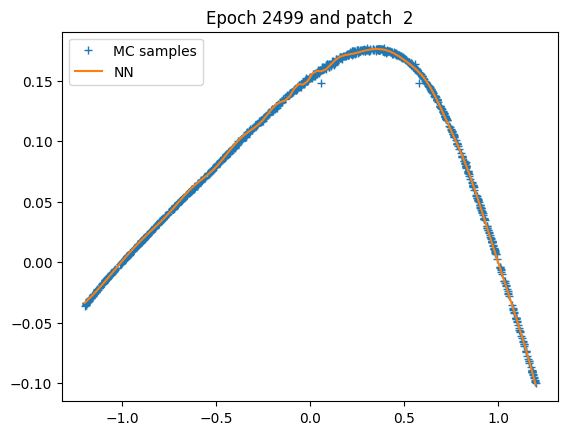

Patch 2: training of u with 2500 epochs take 19.98166823387146 seconds.


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 3: generation of u samples take 4.147822856903076 seconds.
Patch  3: epoch    0 with loss 2.65E+00


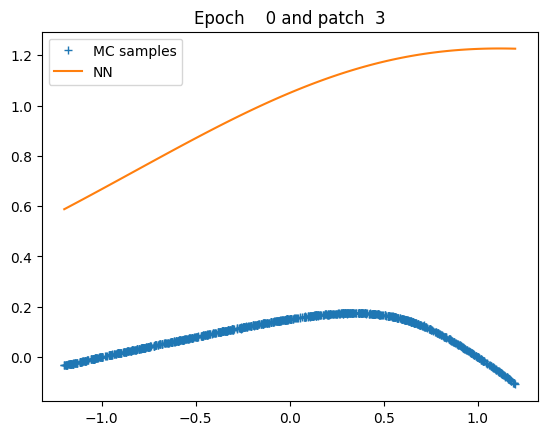

Patch  3: epoch  500 with loss 2.26E-06


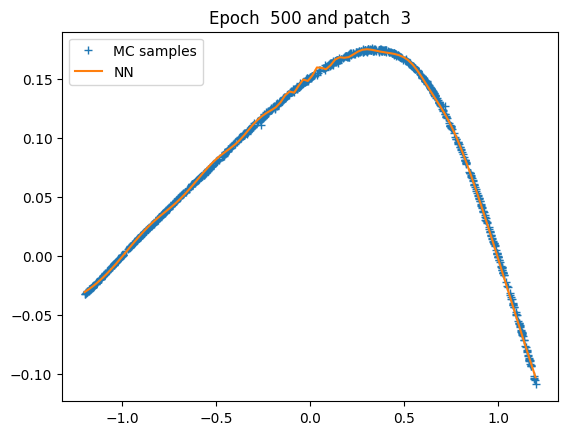

Patch  3: epoch 1000 with loss 2.07E-03


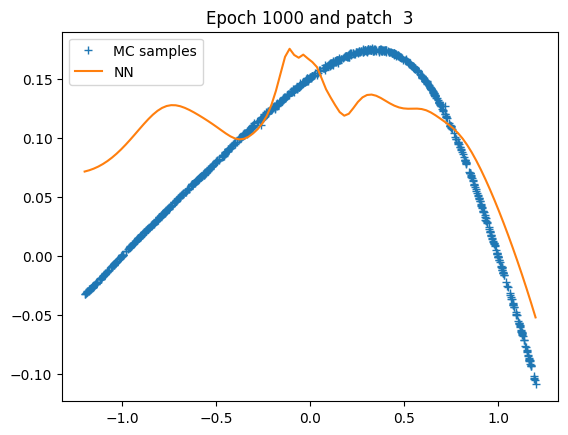

Patch  3: epoch 1500 with loss 8.59E-07


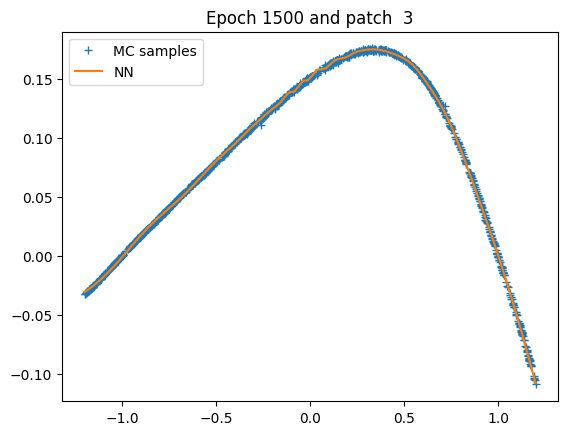

Patch  3: epoch 2000 with loss 6.56E-07


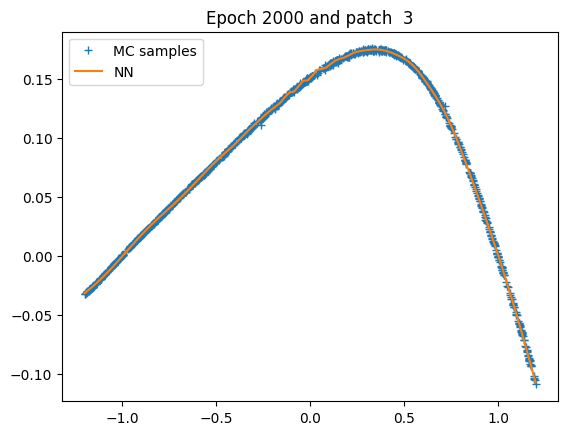

Patch  3: epoch 2499 with loss 6.43E-07


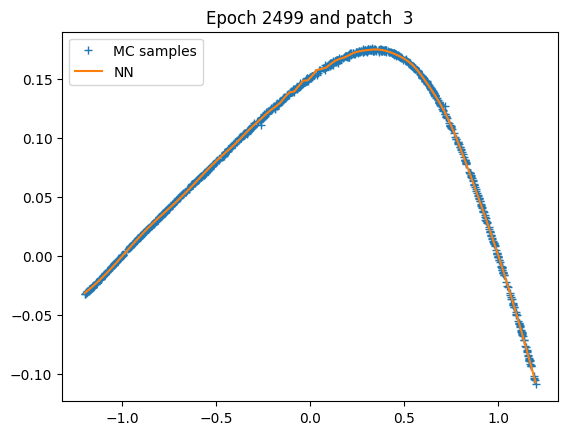

Patch 3: training of u with 2500 epochs take 19.96515989303589 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 93 seconds; L1 error: 3.22E-03; L2 error: 1.87E-05; rel error: INF.
fdb runtime: 0 seconds; total runtime: 93 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


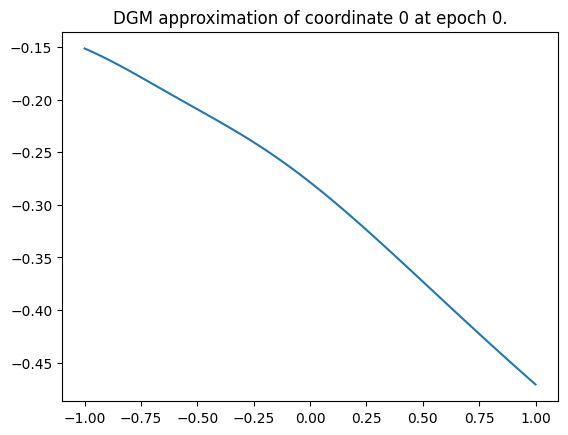

Epoch 0 with loss 0.7458992600440979


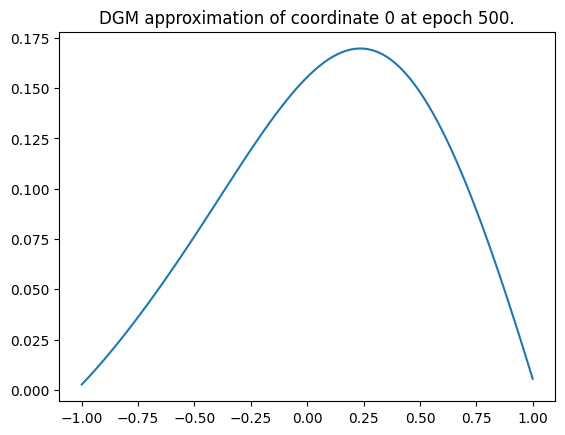

Epoch 500 with loss 0.00018554362759459764


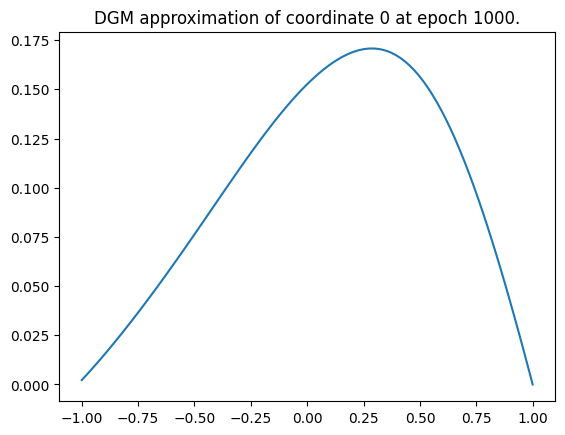

Epoch 1000 with loss 5.853109178133309e-05


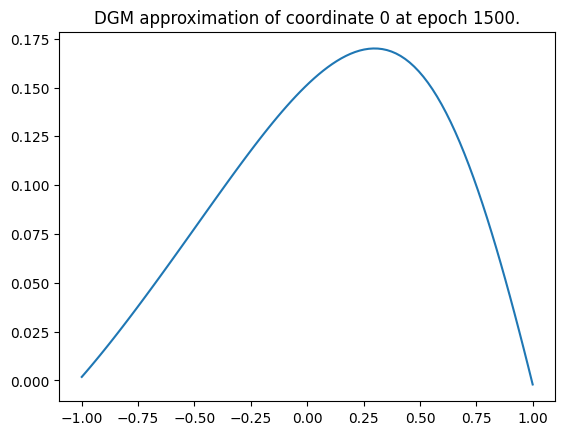

Epoch 1500 with loss 3.263021426391788e-05


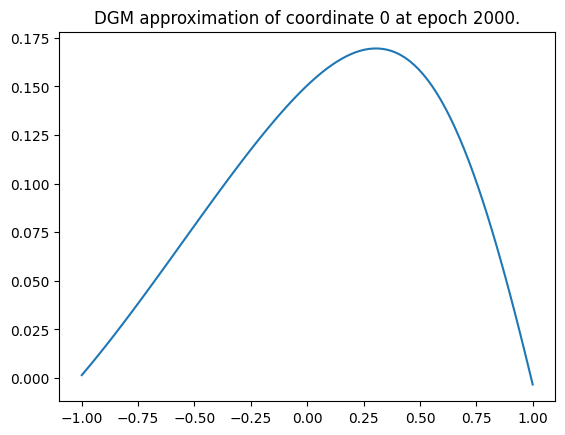

Epoch 2000 with loss 1.9738768969546072e-05


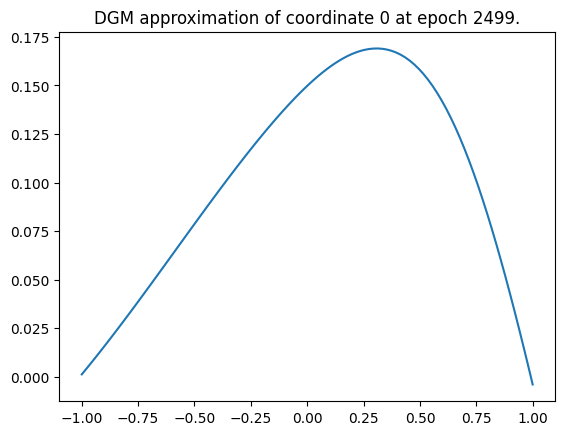

Epoch 2499 with loss 1.6760195649112575e-05
Training of neural network with 2500 epochs take 94.72666263580322 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 95 seconds; L1 error: 8.60E-04; L2 error: 1.19E-06; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


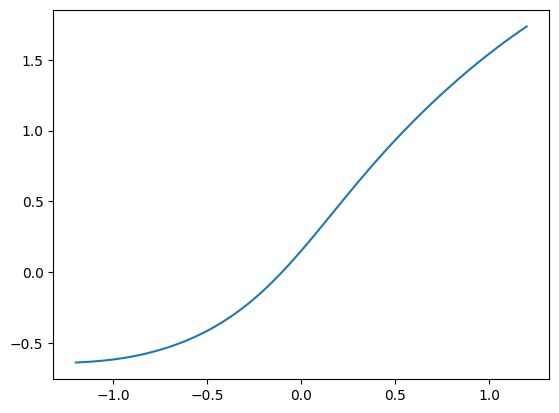

Epoch 0 with loss 0.7366040349006653


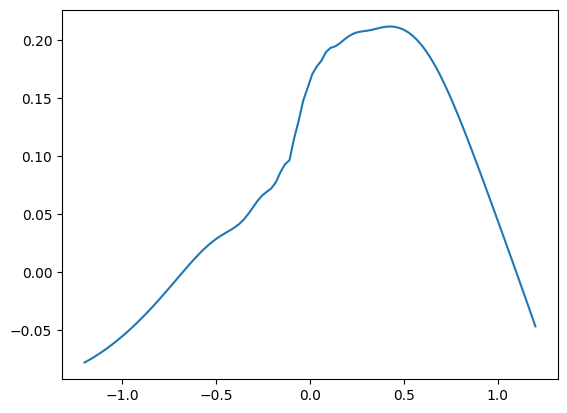

Epoch 500 with loss 0.00047582705155946314


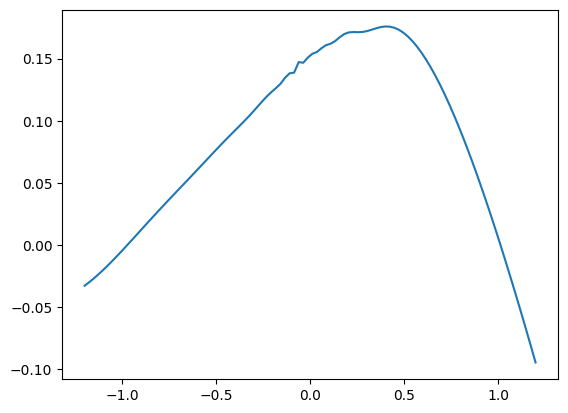

Epoch 1000 with loss 3.098524030065164e-05


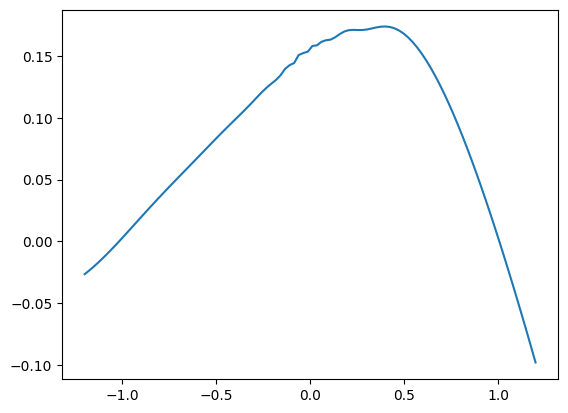

Epoch 1500 with loss 4.6751112677156925e-05


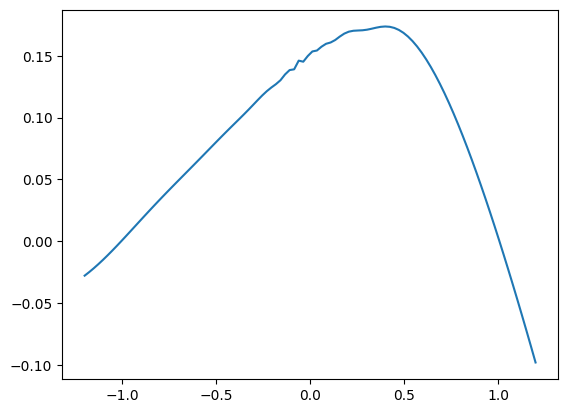

Epoch 2000 with loss 3.2370218832511455e-05


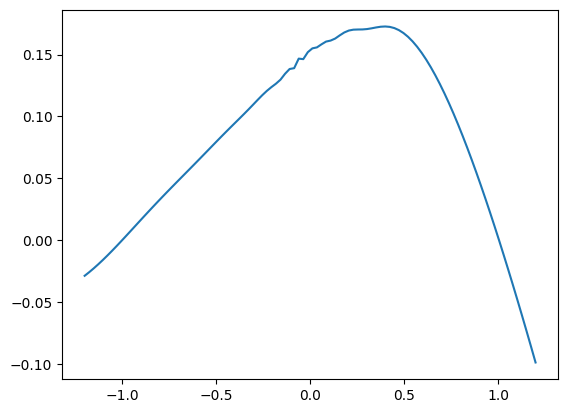

Epoch 2499 with loss 4.902901127934456e-05
Training of neural network with 2500 epochs take 146.91218185424805 seconds.
Time taken: 147 seconds; L1 error: 2.46E-03; L2 error: 1.16E-05; rel error: INF.




######## Summary for deep branching method
runtime:        93
fdb runtime:    0
total runtime:  93
mean L1 error:  3.22E-03
std L1 error:   0.00E+00
mean L2 error:  1.87E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        95
mean L1 error:  8.60E-04
std L1 error:   0.00E+00
mean L2 error:  1.19E-06
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        147
mean L1 error:  2.46E-03
std L1 error:   0.00E+00
mean L2 error:  1.16E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


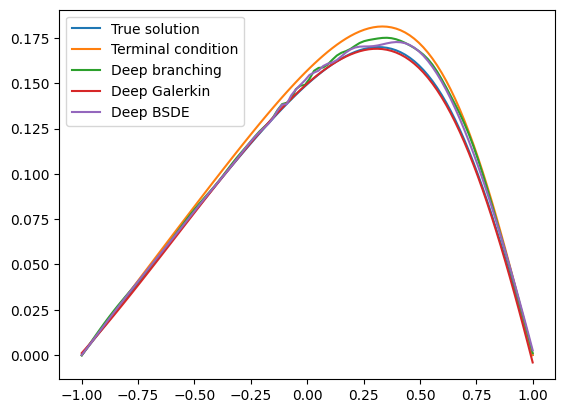

In [6]:
dim = 1
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True,                     
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=4, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 2

Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 20.658080577850342 seconds.
Patch  0: epoch    0 with loss 6.91E-01


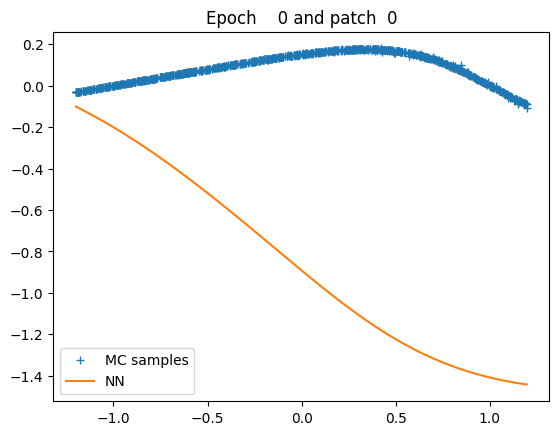

Patch  0: epoch  500 with loss 6.81E-06


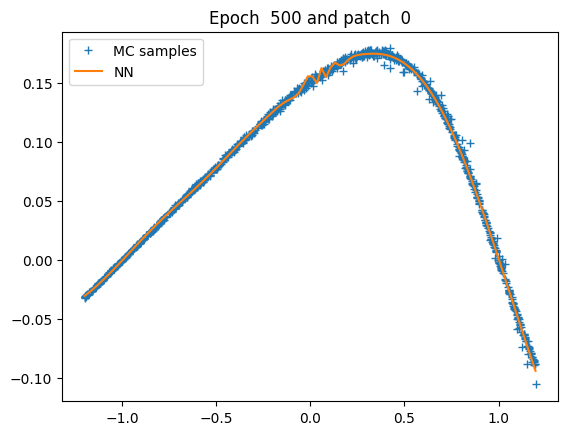

Patch  0: epoch 1000 with loss 5.44E-06


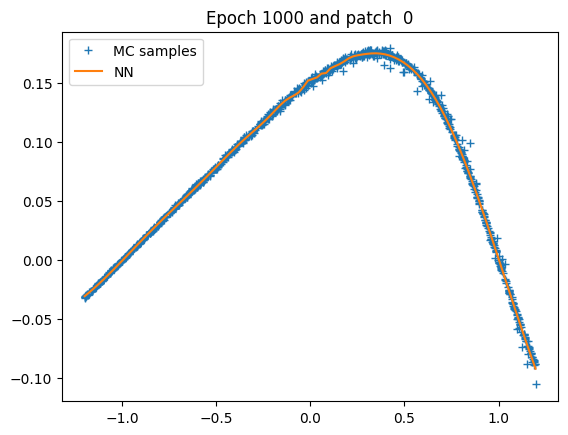

Patch  0: epoch 1500 with loss 5.40E-06


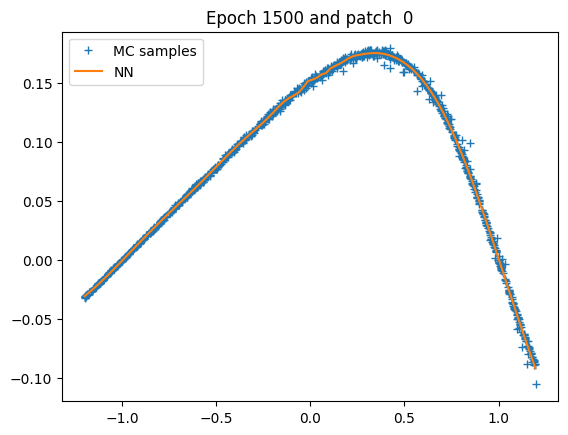

Patch  0: epoch 2000 with loss 5.37E-06


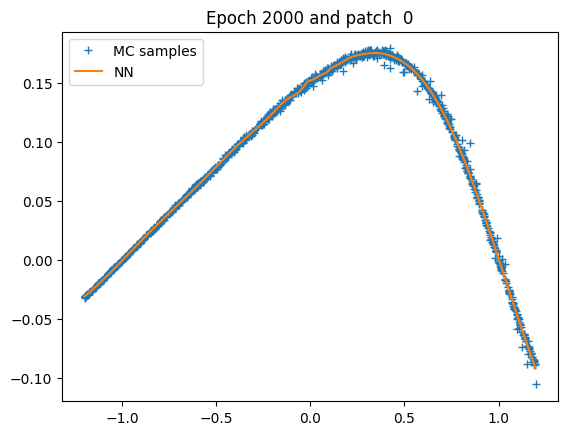

Patch  0: epoch 2499 with loss 5.36E-06


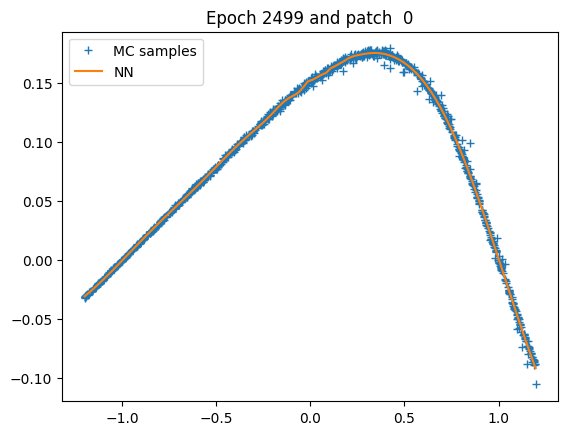

Patch 0: training of u with 2500 epochs take 17.897683143615723 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 38 seconds; L1 error: 3.14E-03; L2 error: 2.00E-05; rel error: INF.
fdb runtime: 0 seconds; total runtime: 39 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


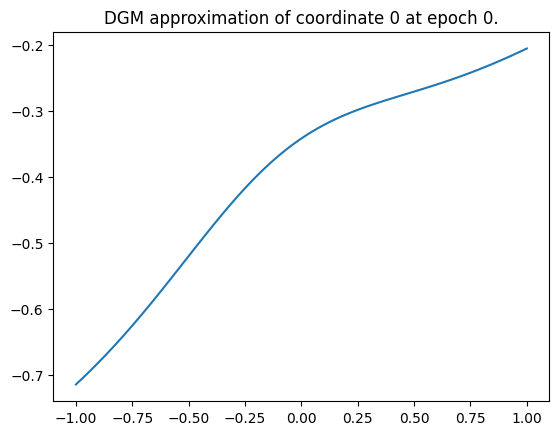

Epoch 0 with loss 2.3626937866210938


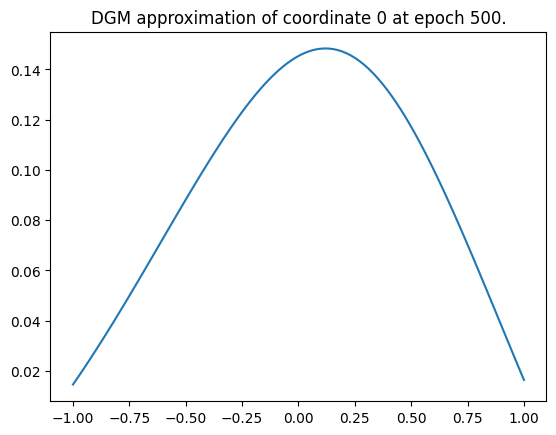

Epoch 500 with loss 0.005492780357599258


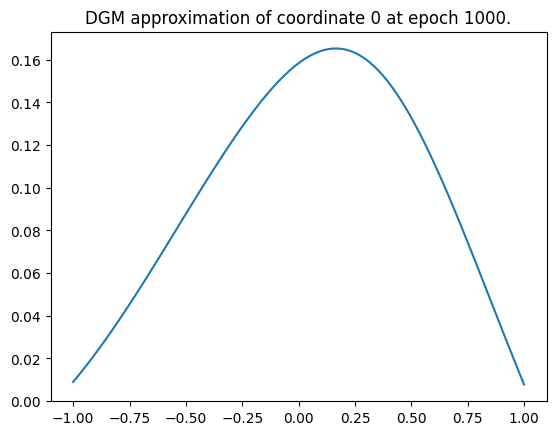

Epoch 1000 with loss 0.004682756029069424


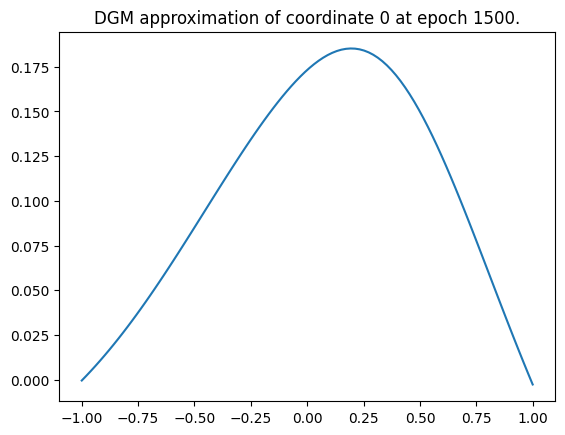

Epoch 1500 with loss 0.004003837238997221


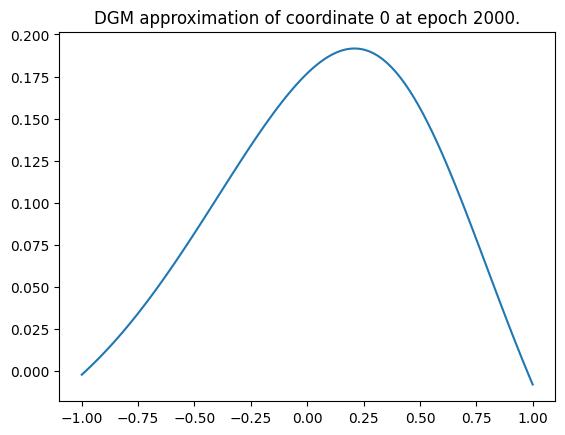

Epoch 2000 with loss 0.0038071004673838615


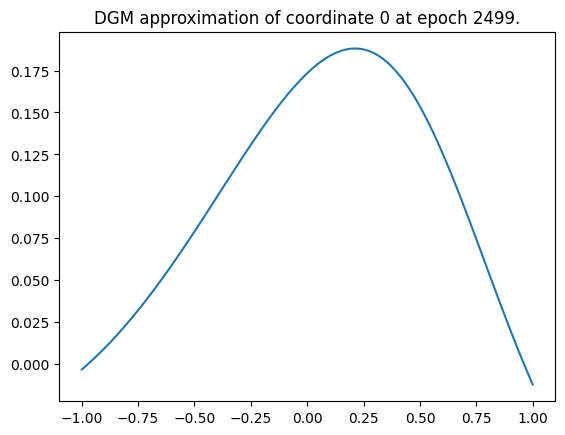

Epoch 2499 with loss 0.0036794934421777725
Training of neural network with 2500 epochs take 141.856449842453 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 142 seconds; L1 error: 1.40E-02; L2 error: 2.67E-04; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


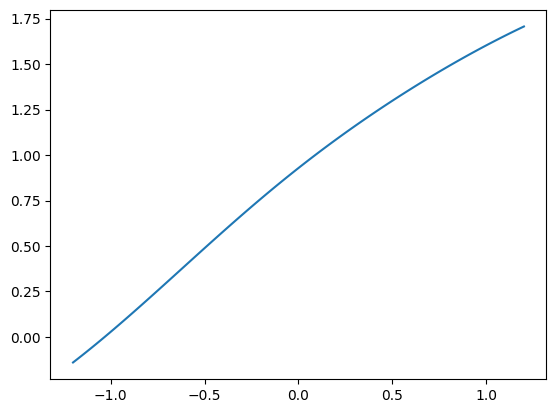

Epoch 0 with loss 0.8213662505149841


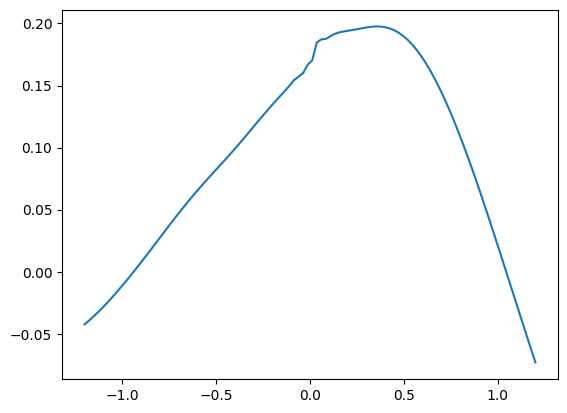

Epoch 500 with loss 0.0003082835173700005


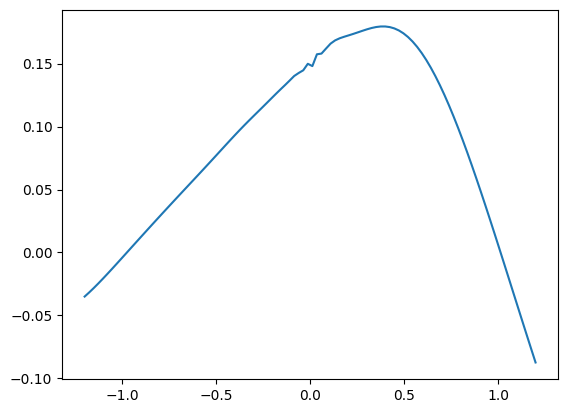

Epoch 1000 with loss 4.195662040729076e-05


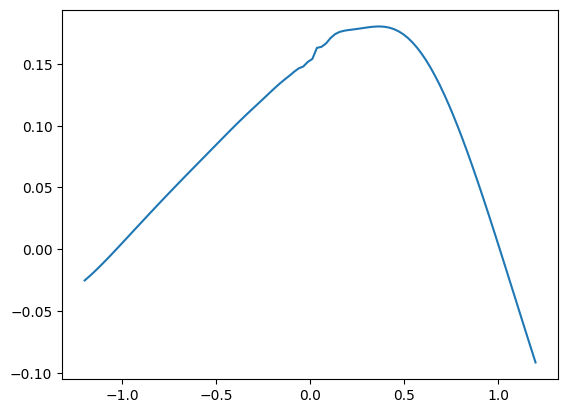

Epoch 1500 with loss 0.0001062963274307549


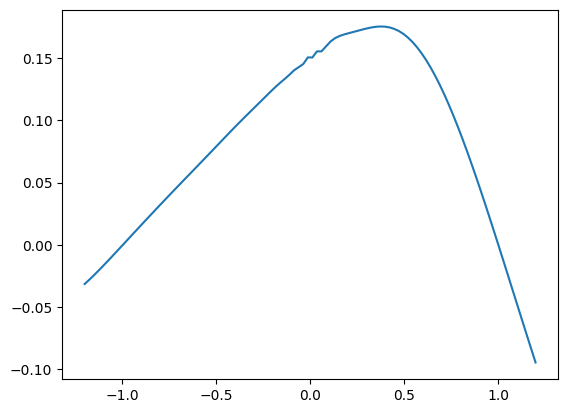

Epoch 2000 with loss 3.213802119717002e-05


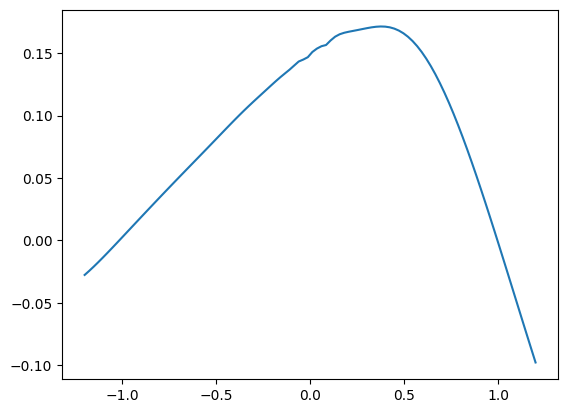

Epoch 2499 with loss 3.686739000841044e-05
Training of neural network with 2500 epochs take 145.50560927391052 seconds.
Time taken: 146 seconds; L1 error: 2.39E-03; L2 error: 8.80E-06; rel error: INF.




######## Summary for deep branching method
runtime:        38
fdb runtime:    0
total runtime:  39
mean L1 error:  3.14E-03
std L1 error:   0.00E+00
mean L2 error:  2.00E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        142
mean L1 error:  1.40E-02
std L1 error:   0.00E+00
mean L2 error:  2.67E-04
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        146
mean L1 error:  2.39E-03
std L1 error:   0.00E+00
mean L2 error:  8.80E-06
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


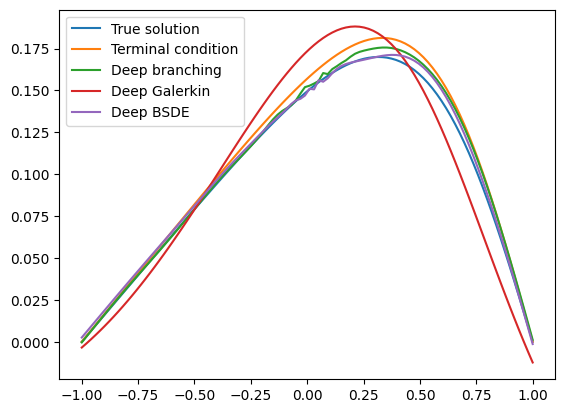

In [7]:
dim = 2
T=0.1/dim

grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 3

Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 39.72332715988159 seconds.
Patch  0: epoch    0 with loss 3.02E+00


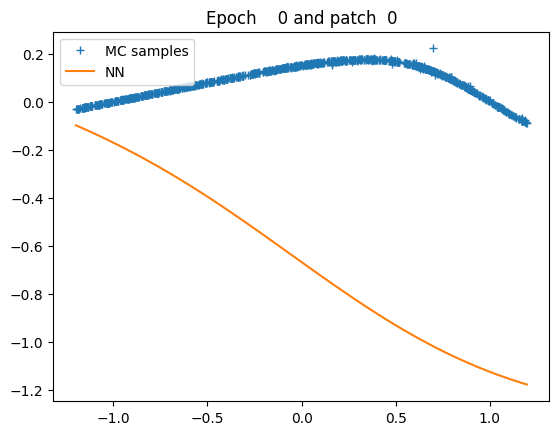

Patch  0: epoch  500 with loss 1.61E-05


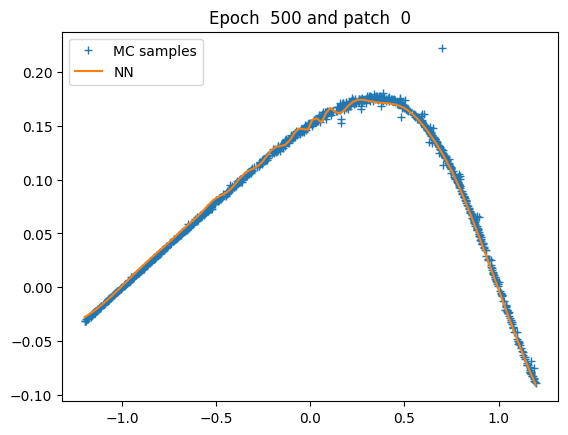

Patch  0: epoch 1000 with loss 1.39E-05


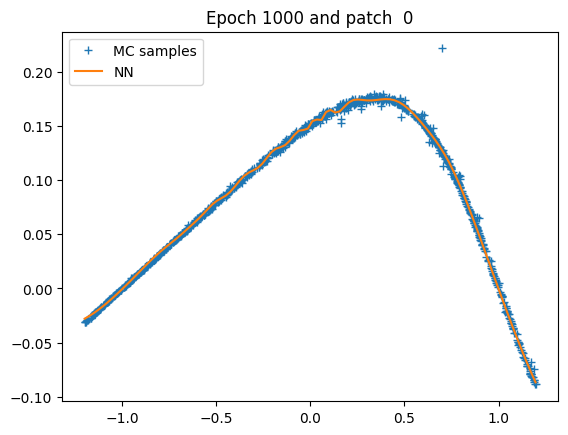

Patch  0: epoch 1500 with loss 1.37E-05


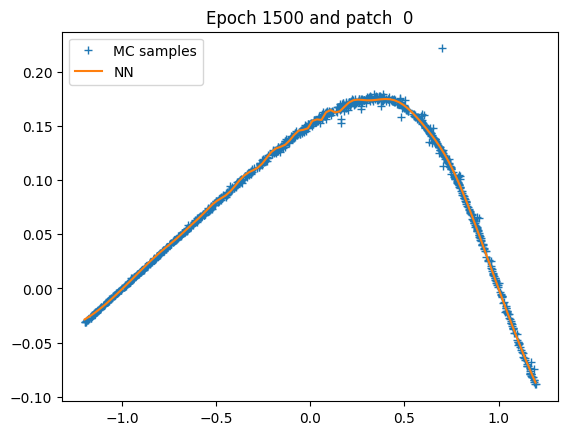

Patch  0: epoch 2000 with loss 1.35E-05


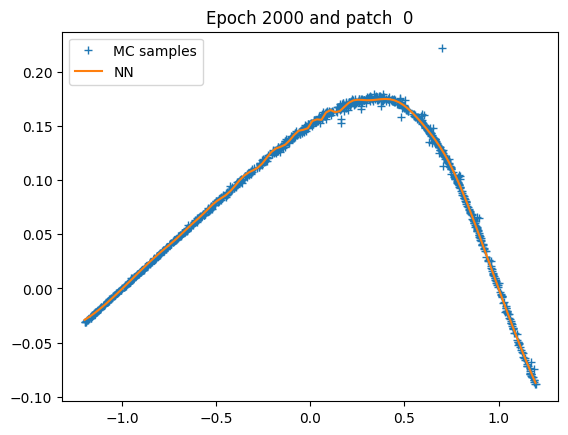

Patch  0: epoch 2499 with loss 1.35E-05


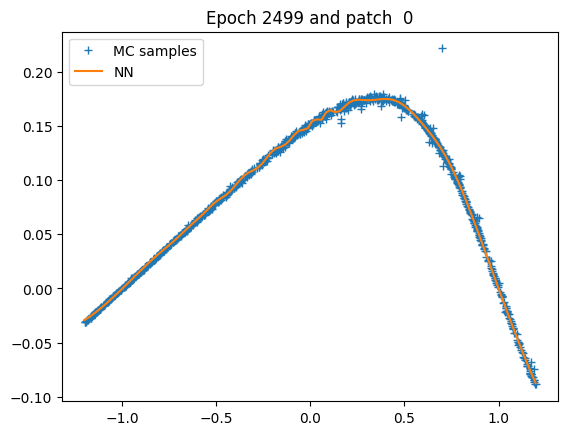

Patch 0: training of u with 2500 epochs take 17.99671745300293 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 56 seconds; L1 error: 3.38E-03; L2 error: 2.23E-05; rel error: INF.
fdb runtime: 2 seconds; total runtime: 58 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


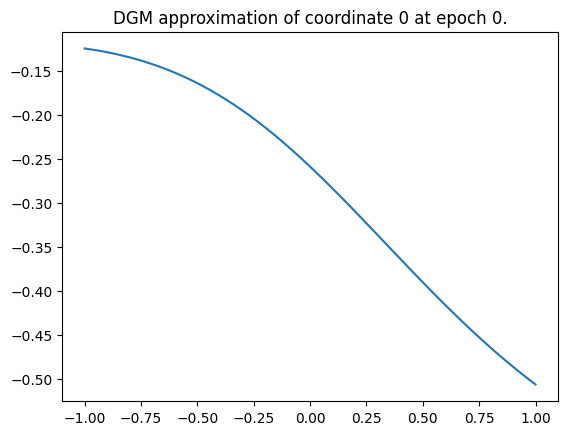

Epoch 0 with loss 0.8775405883789062


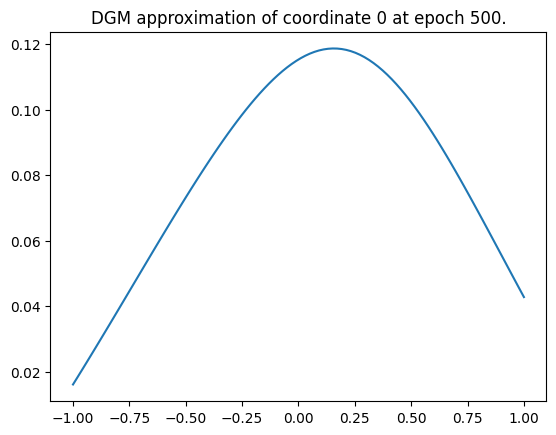

Epoch 500 with loss 0.007701632101088762


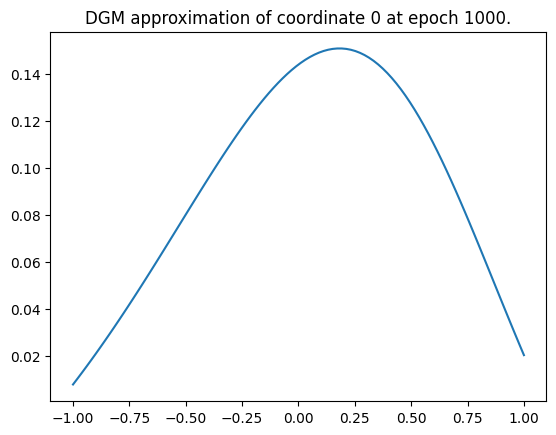

Epoch 1000 with loss 0.006351064890623093


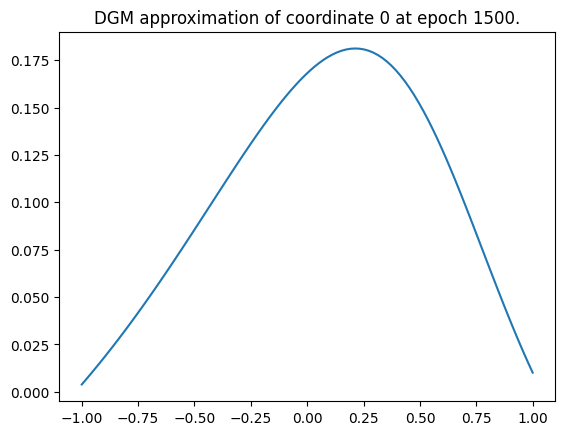

Epoch 1500 with loss 0.005807616747915745


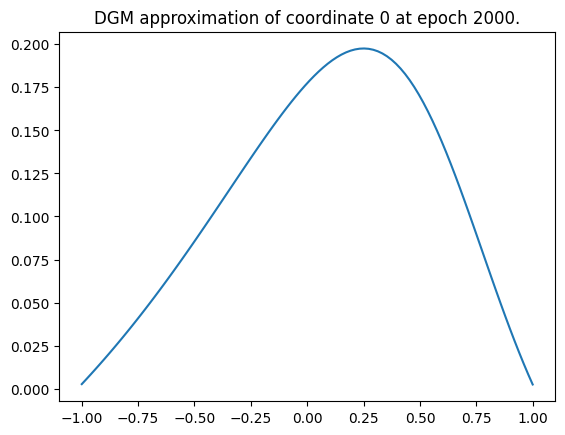

Epoch 2000 with loss 0.005086131393909454


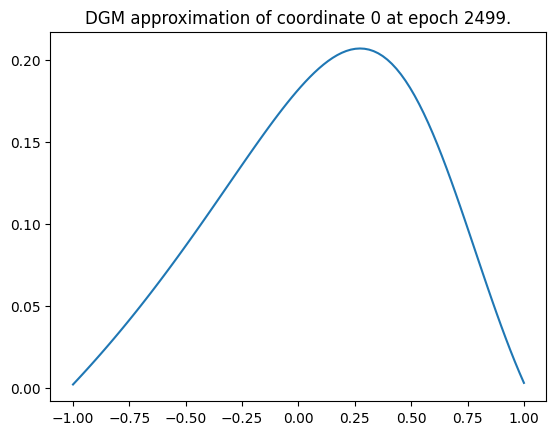

Epoch 2499 with loss 0.004817236680537462
Training of neural network with 2500 epochs take 189.892231464386 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 190 seconds; L1 error: 1.60E-02; L2 error: 4.33E-04; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


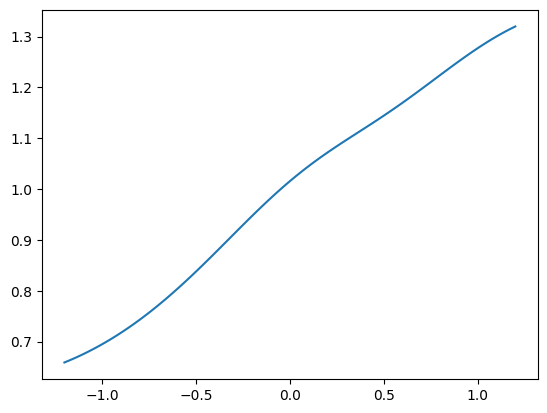

Epoch 0 with loss 0.8056908249855042


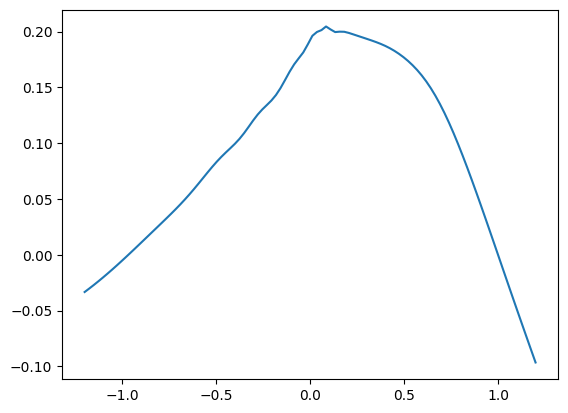

Epoch 500 with loss 0.0003157989995088428


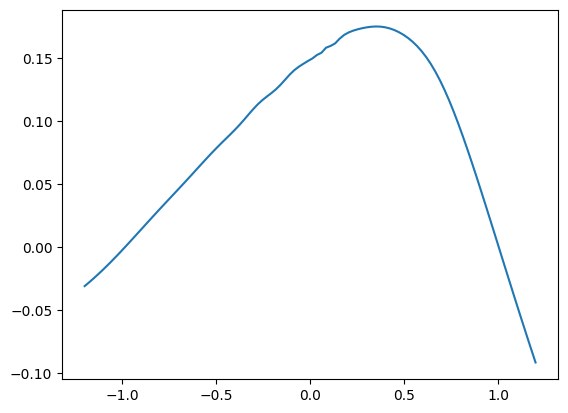

Epoch 1000 with loss 8.37332772789523e-05


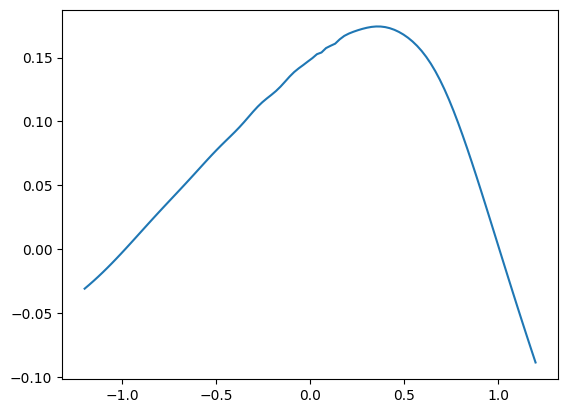

Epoch 1500 with loss 9.531206160318106e-05


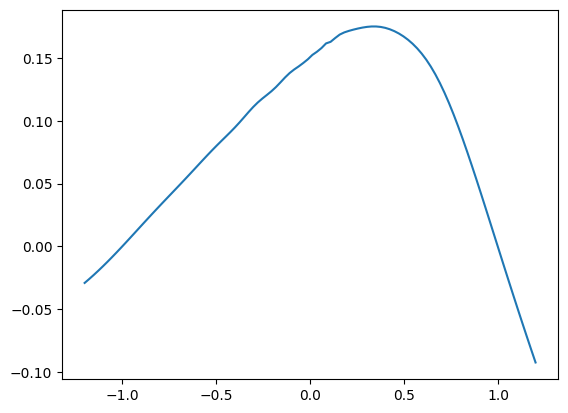

Epoch 2000 with loss 3.129131437162869e-05


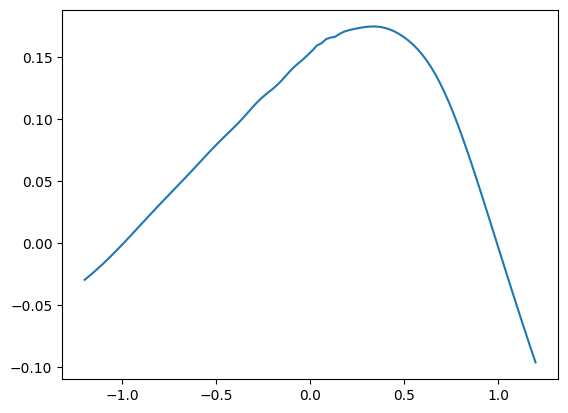

Epoch 2499 with loss 6.88869331497699e-05
Training of neural network with 2500 epochs take 146.12615990638733 seconds.
Time taken: 146 seconds; L1 error: 3.14E-03; L2 error: 1.82E-05; rel error: INF.




######## Summary for deep branching method
runtime:        56
fdb runtime:    2
total runtime:  58
mean L1 error:  3.38E-03
std L1 error:   0.00E+00
mean L2 error:  2.23E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        190
mean L1 error:  1.60E-02
std L1 error:   0.00E+00
mean L2 error:  4.33E-04
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        146
mean L1 error:  3.14E-03
std L1 error:   0.00E+00
mean L2 error:  1.82E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


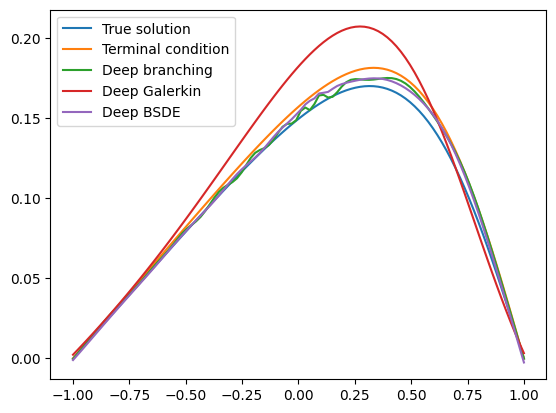

In [8]:
dim = 3
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 4

Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 60.46948528289795 seconds.
Patch  0: epoch    0 with loss 1.00E-01


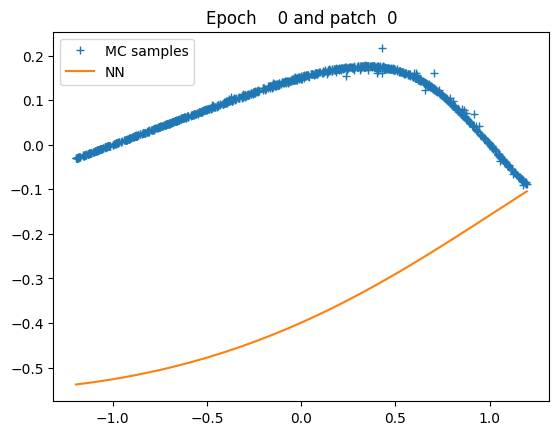

Patch  0: epoch  500 with loss 1.14E-05


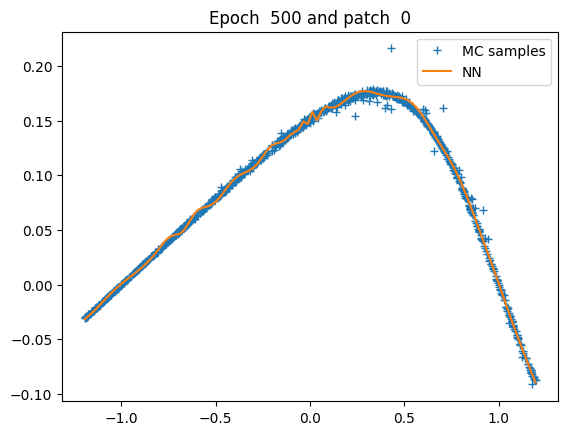

Patch  0: epoch 1000 with loss 8.78E-06


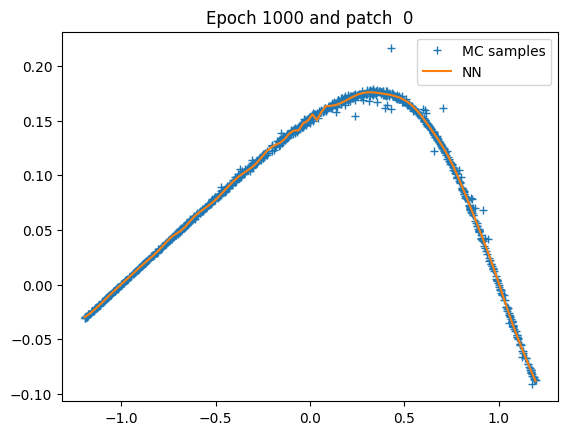

Patch  0: epoch 1500 with loss 8.69E-06


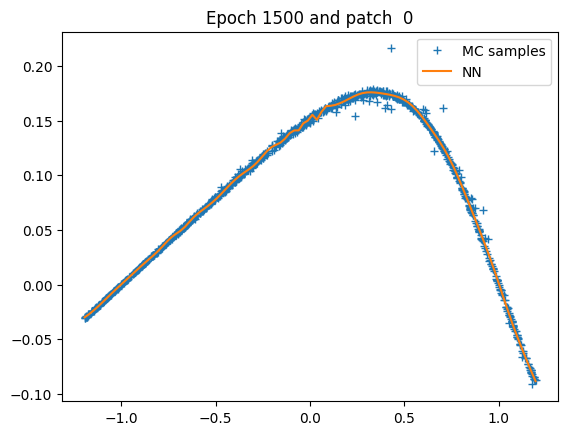

Patch  0: epoch 2000 with loss 8.60E-06


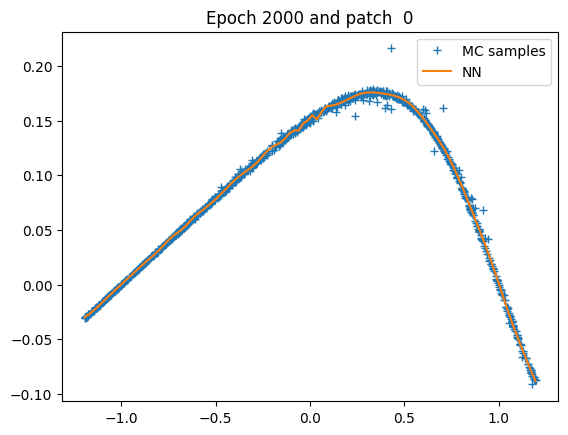

Patch  0: epoch 2499 with loss 8.59E-06


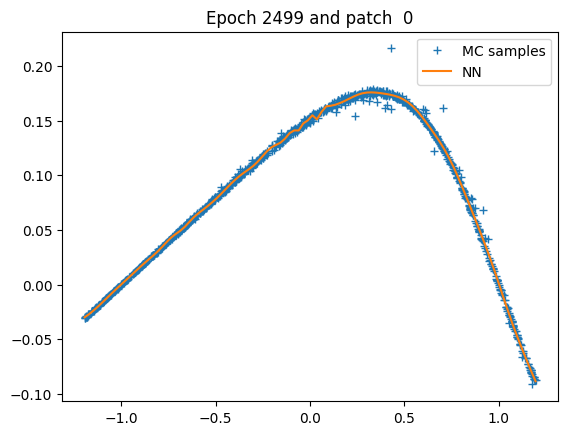

Patch 0: training of u with 2500 epochs take 17.603545904159546 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 72 seconds; L1 error: 3.43E-03; L2 error: 2.33E-05; rel error: INF.
fdb runtime: 6 seconds; total runtime: 78 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


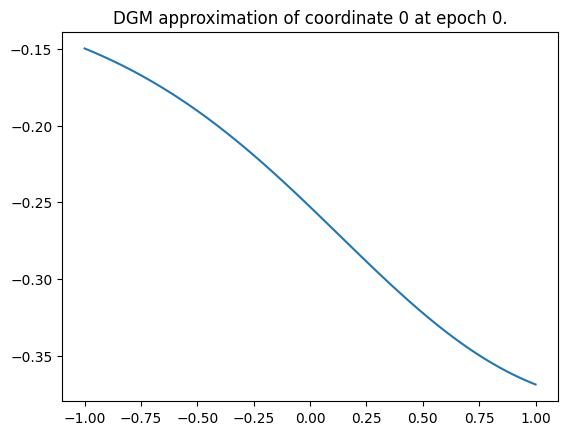

Epoch 0 with loss 0.5201994180679321


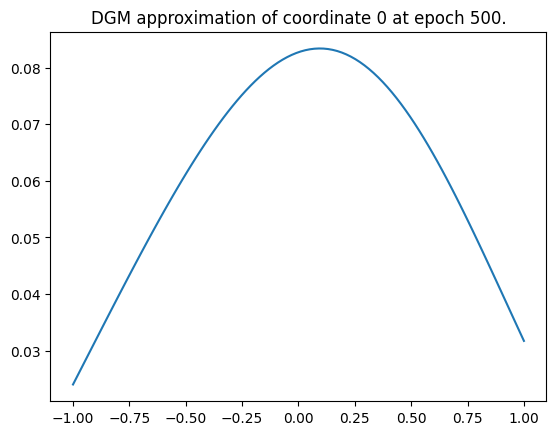

Epoch 500 with loss 0.010127102956175804


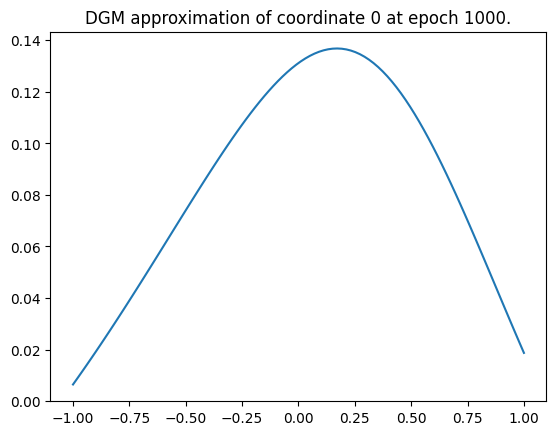

Epoch 1000 with loss 0.007475760765373707


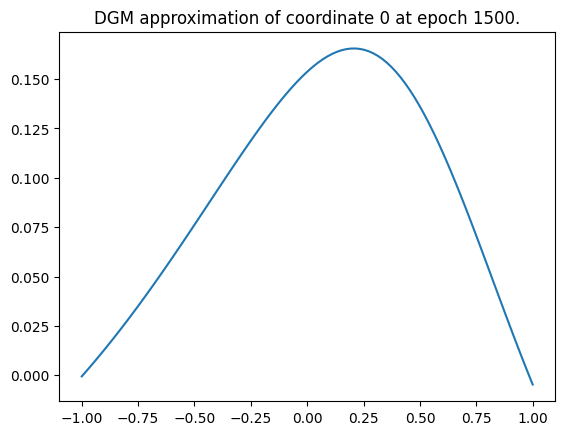

Epoch 1500 with loss 0.006865176372230053


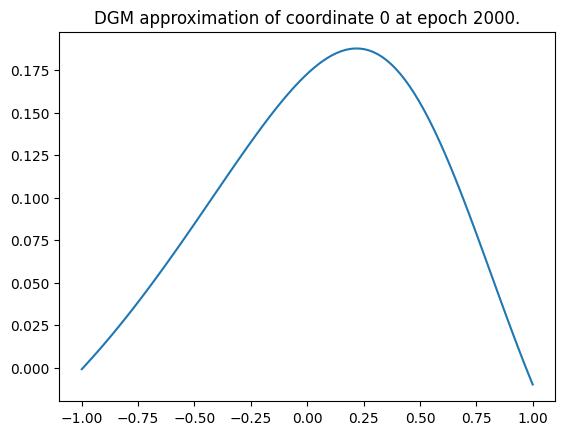

Epoch 2000 with loss 0.006333992816507816


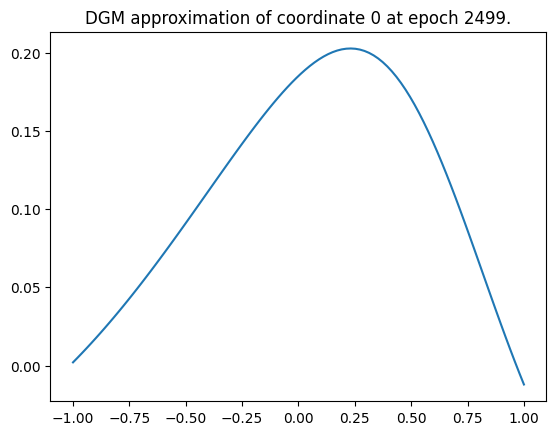

Epoch 2499 with loss 0.005739073269069195
Training of neural network with 2500 epochs take 244.00475764274597 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 244 seconds; L1 error: 1.78E-02; L2 error: 4.55E-04; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


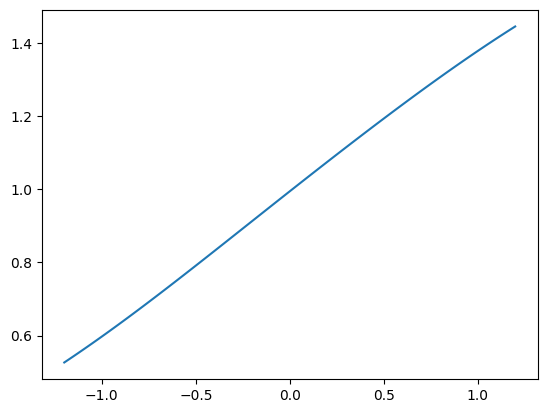

Epoch 0 with loss 0.665654718875885


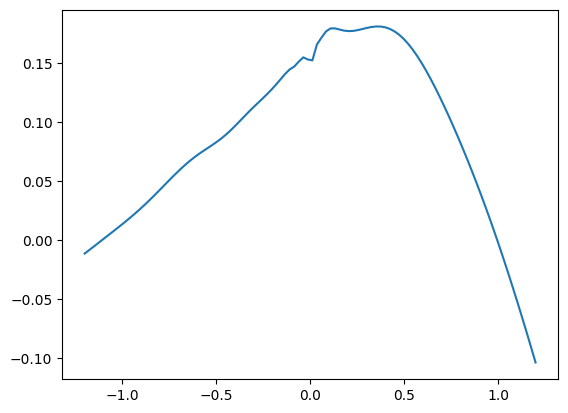

Epoch 500 with loss 0.00011553079821169376


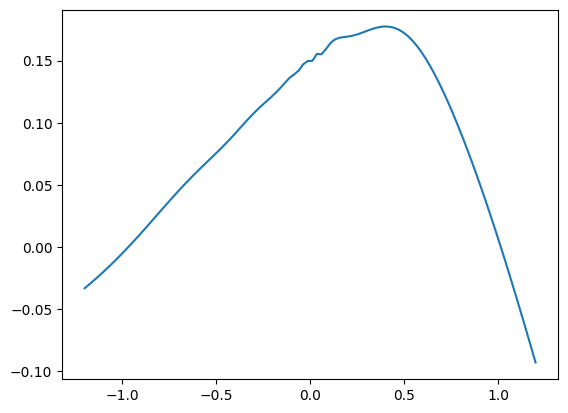

Epoch 1000 with loss 8.933911885833368e-05


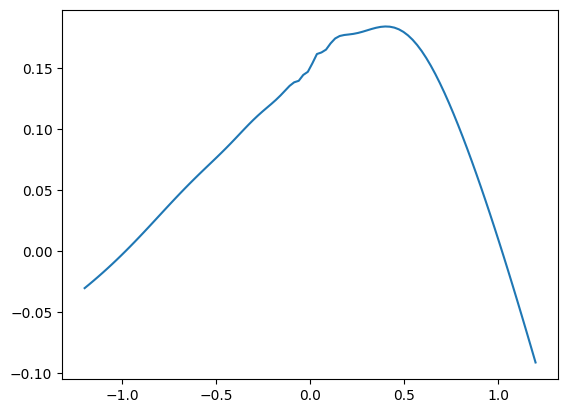

Epoch 1500 with loss 5.60542284802068e-05


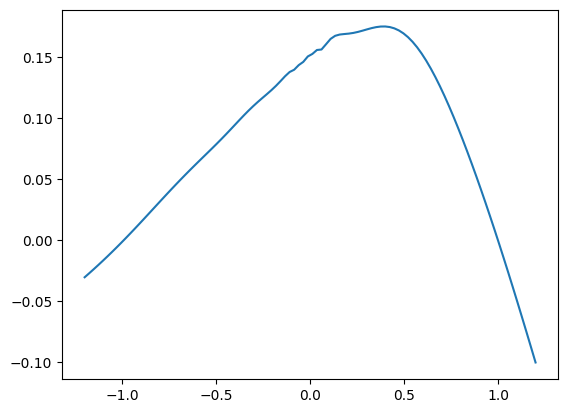

Epoch 2000 with loss 8.006525604287162e-05


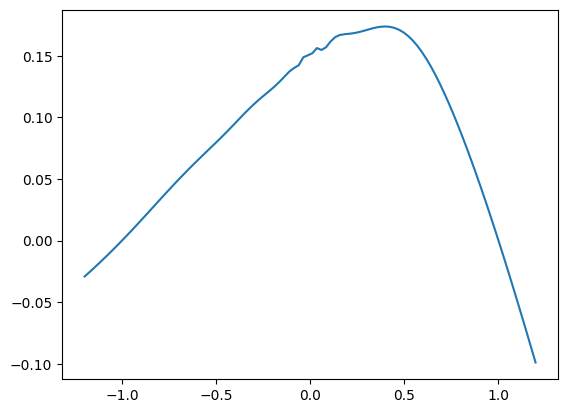

Epoch 2499 with loss 5.616034832200967e-05
Training of neural network with 2500 epochs take 149.4118824005127 seconds.
Time taken: 149 seconds; L1 error: 2.65E-03; L2 error: 1.47E-05; rel error: INF.




######## Summary for deep branching method
runtime:        72
fdb runtime:    6
total runtime:  78
mean L1 error:  3.43E-03
std L1 error:   0.00E+00
mean L2 error:  2.33E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        244
mean L1 error:  1.78E-02
std L1 error:   0.00E+00
mean L2 error:  4.55E-04
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        149
mean L1 error:  2.65E-03
std L1 error:   0.00E+00
mean L2 error:  1.47E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


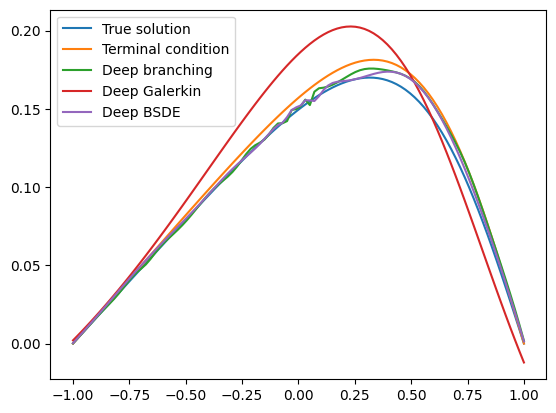

In [9]:
dim = 4
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 5

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 89.34841585159302 seconds.
Patch  0: epoch    0 with loss 2.08E+00


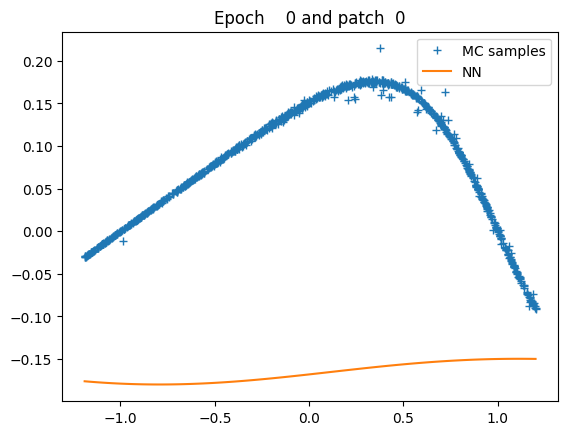

Patch  0: epoch  500 with loss 1.07E-05


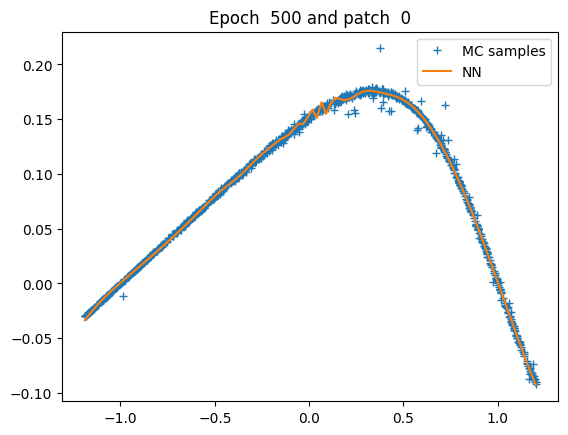

Patch  0: epoch 1000 with loss 9.89E-06


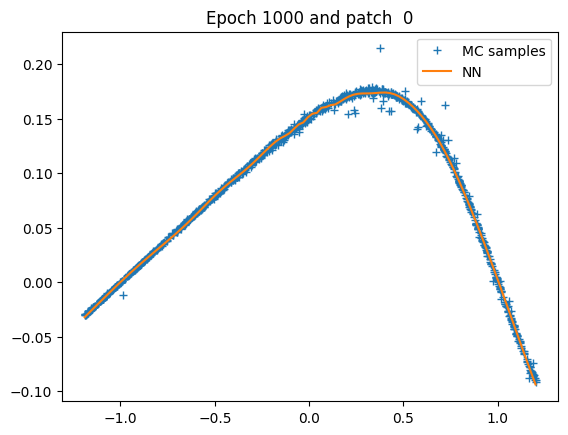

Patch  0: epoch 1500 with loss 9.41E-06


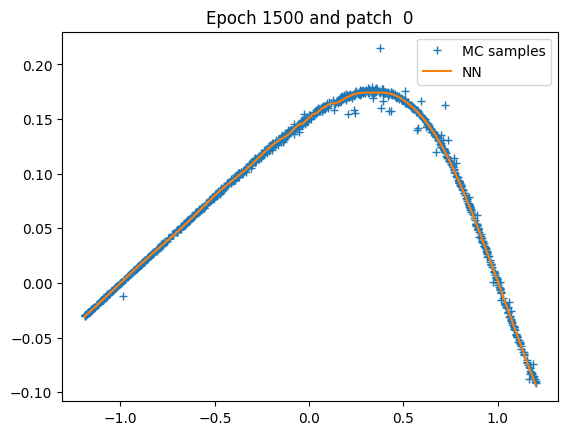

Patch  0: epoch 2000 with loss 9.18E-06


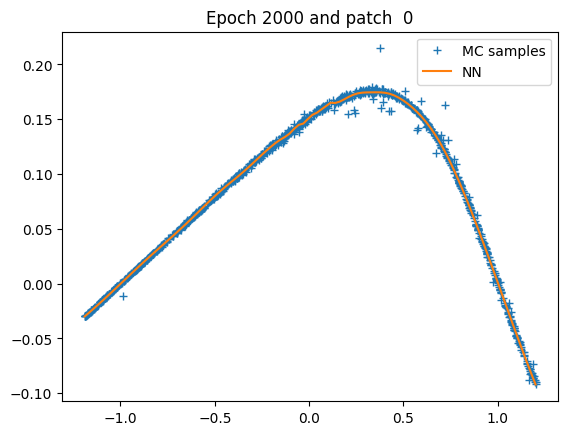

Patch  0: epoch 2499 with loss 9.16E-06


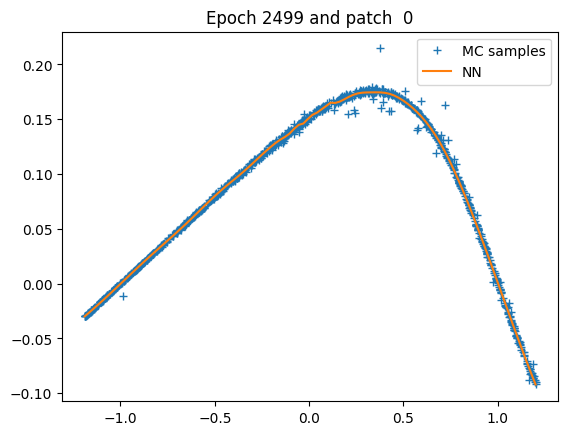

Patch 0: training of u with 2500 epochs take 18.514440536499023 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 89 seconds; L1 error: 2.86E-03; L2 error: 1.70E-05; rel error: INF.
fdb runtime: 19 seconds; total runtime: 108 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


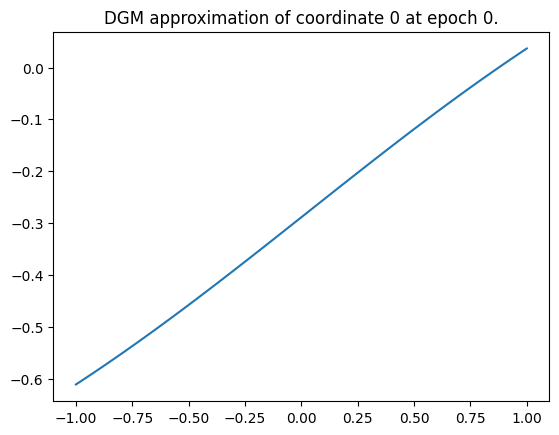

Epoch 0 with loss 1.4307255744934082


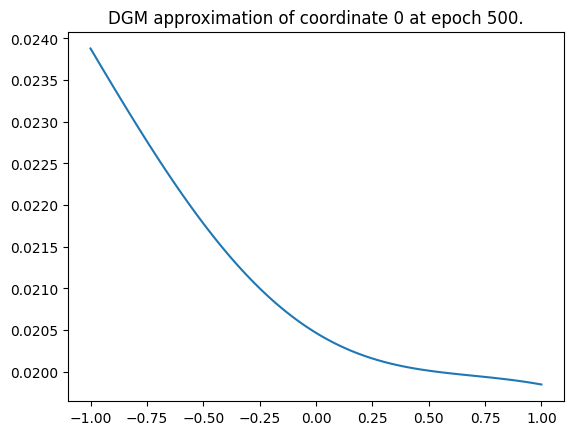

Epoch 500 with loss 0.013726147823035717


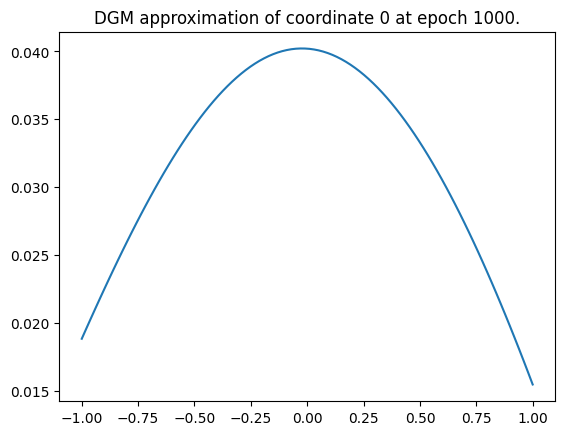

Epoch 1000 with loss 0.011811582371592522


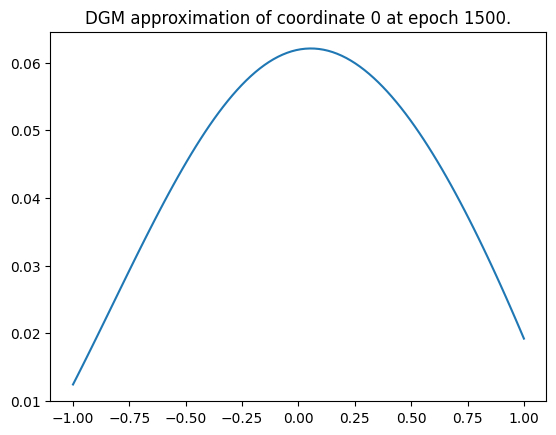

Epoch 1500 with loss 0.010489743202924728


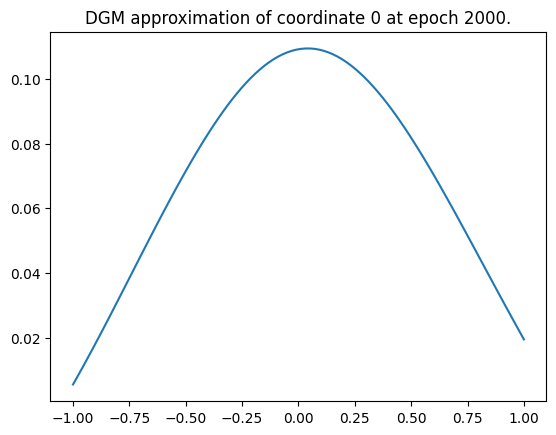

Epoch 2000 with loss 0.008708388544619083


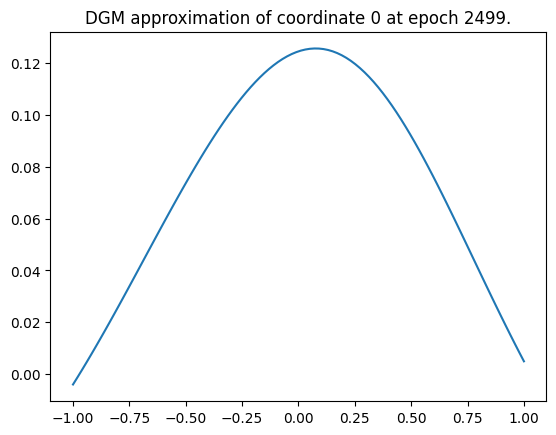

Epoch 2499 with loss 0.0077490853145718575
Training of neural network with 2500 epochs take 295.4481074810028 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 295 seconds; L1 error: 2.75E-02; L2 error: 1.30E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


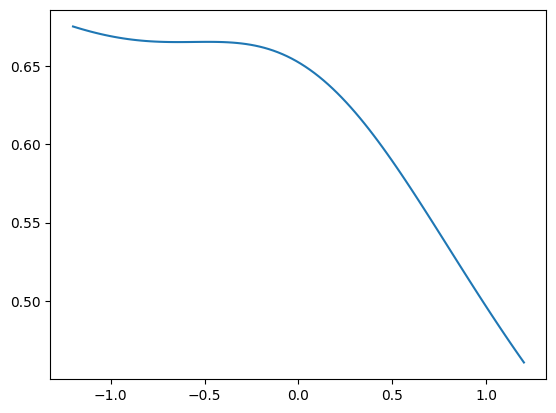

Epoch 0 with loss 0.7858270406723022


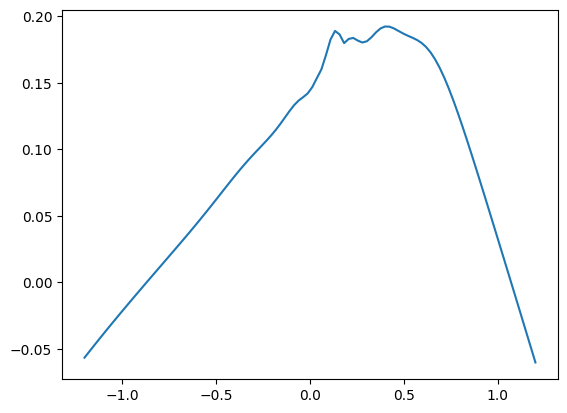

Epoch 500 with loss 0.00037313171196728945


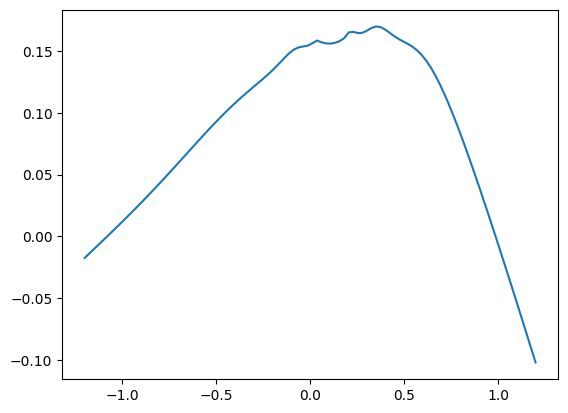

Epoch 1000 with loss 0.00015321947284974158


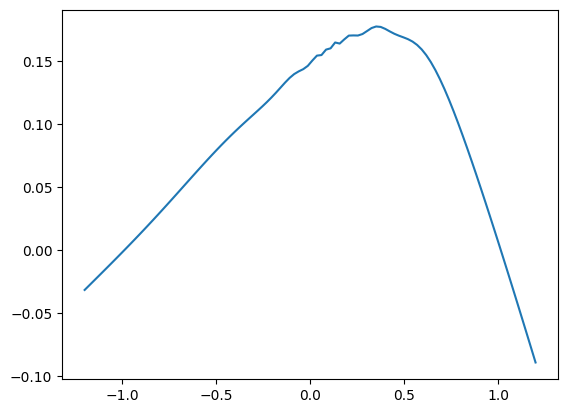

Epoch 1500 with loss 0.00018698738131206483


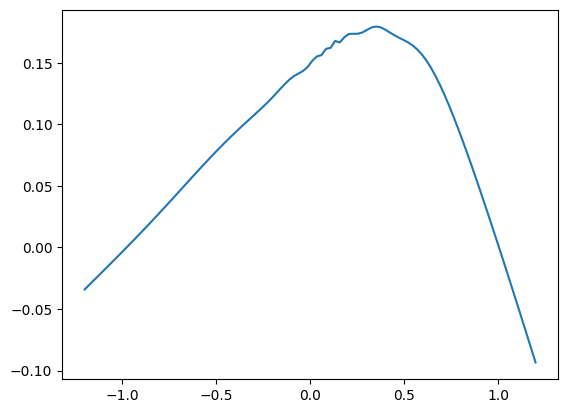

Epoch 2000 with loss 3.4373311791568995e-05


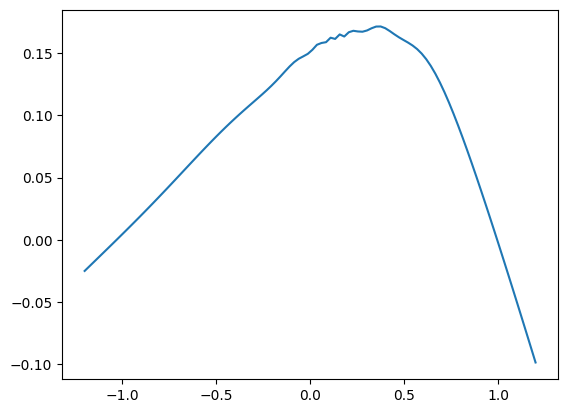

Epoch 2499 with loss 6.119969475548714e-05
Training of neural network with 2500 epochs take 151.2909460067749 seconds.
Time taken: 151 seconds; L1 error: 2.70E-03; L2 error: 9.63E-06; rel error: INF.




######## Summary for deep branching method
runtime:        89
fdb runtime:    19
total runtime:  108
mean L1 error:  2.86E-03
std L1 error:   0.00E+00
mean L2 error:  1.70E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        295
mean L1 error:  2.75E-02
std L1 error:   0.00E+00
mean L2 error:  1.30E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        151
mean L1 error:  2.70E-03
std L1 error:   0.00E+00
mean L2 error:  9.63E-06
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


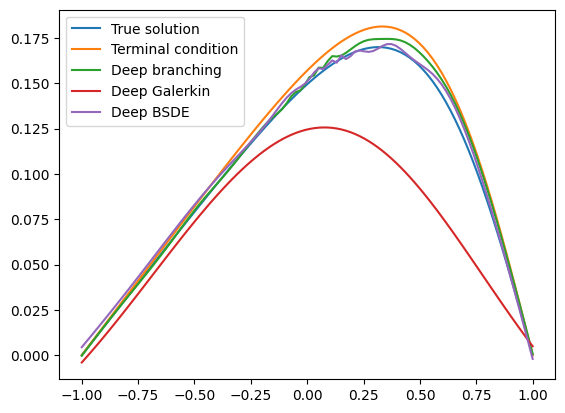

In [10]:
dim = 5
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 6

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 106.10826420783997 seconds.
Patch  0: epoch    0 with loss 4.86E+00


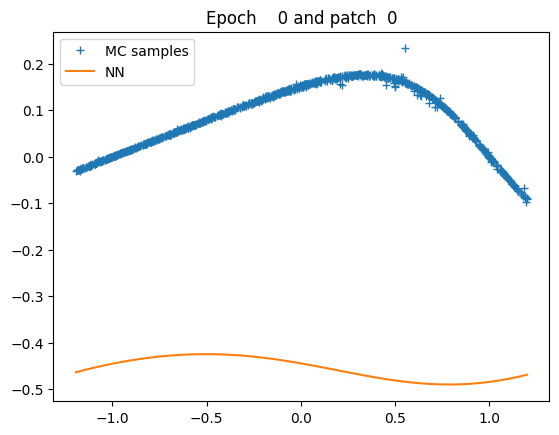

Patch  0: epoch  500 with loss 1.30E-05


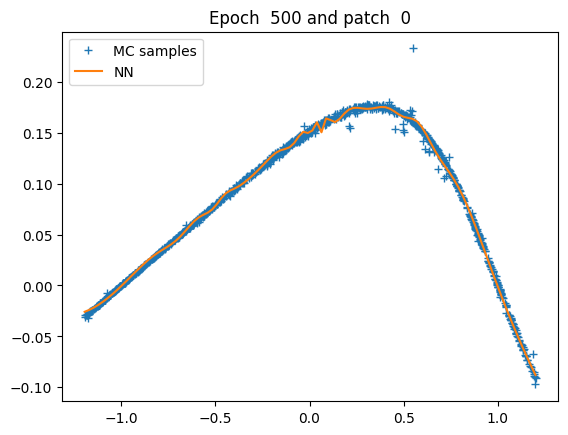

Patch  0: epoch 1000 with loss 1.12E-05


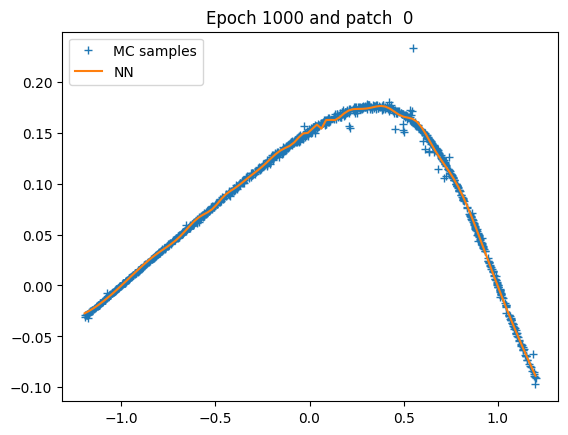

Patch  0: epoch 1500 with loss 1.11E-05


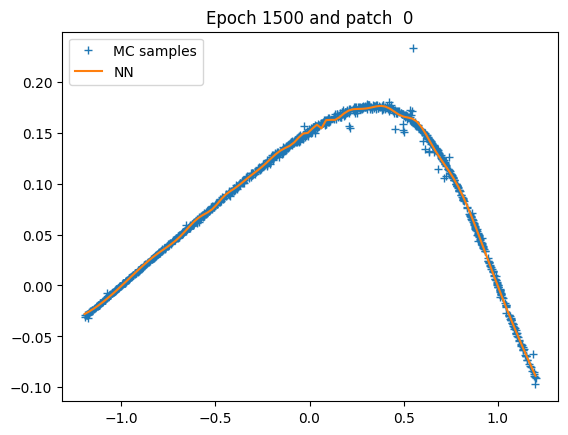

Patch  0: epoch 2000 with loss 1.10E-05


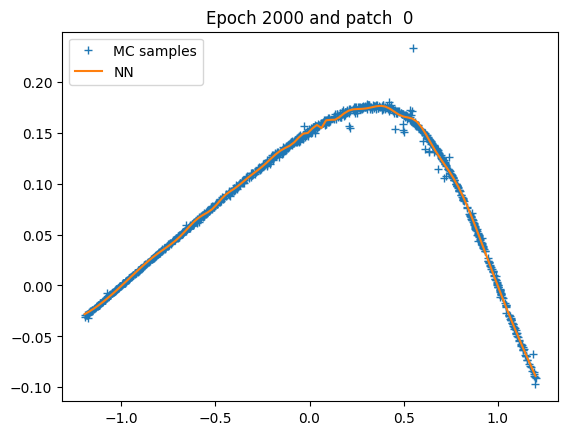

Patch  0: epoch 2499 with loss 1.09E-05


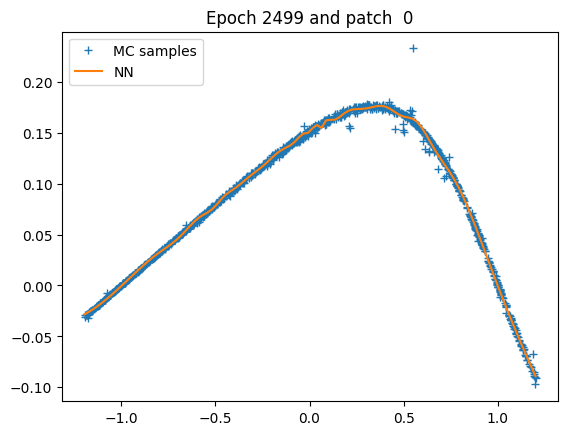

Patch 0: training of u with 2500 epochs take 18.24125909805298 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 104 seconds; L1 error: 3.23E-03; L2 error: 2.05E-05; rel error: INF.
fdb runtime: 21 seconds; total runtime: 125 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


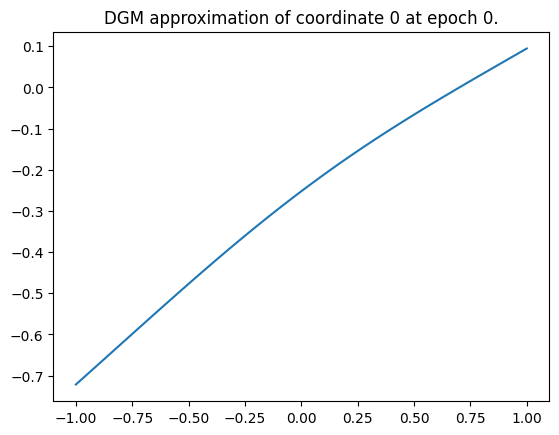

Epoch 0 with loss 0.9966408610343933


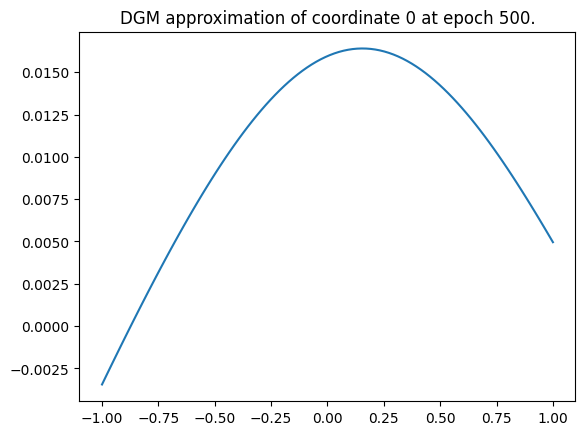

Epoch 500 with loss 0.014900119975209236


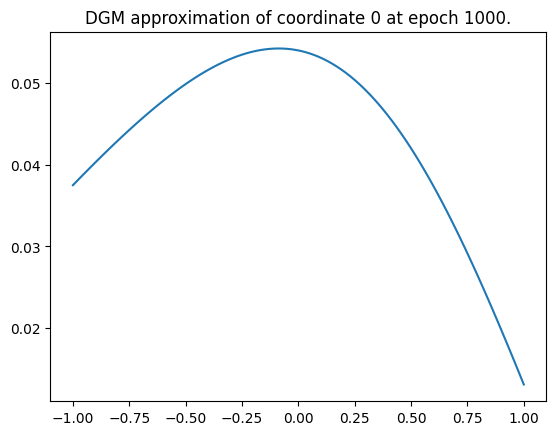

Epoch 1000 with loss 0.012024959549307823


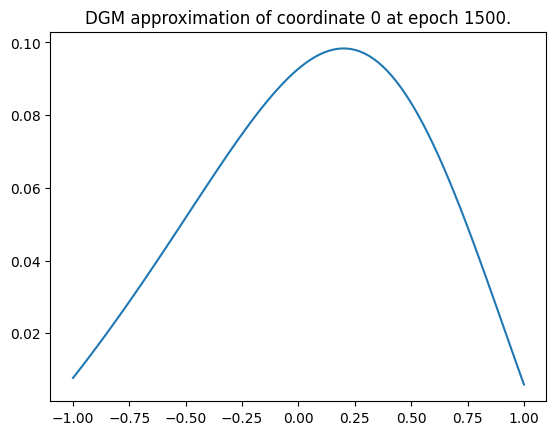

Epoch 1500 with loss 0.008378817699849606


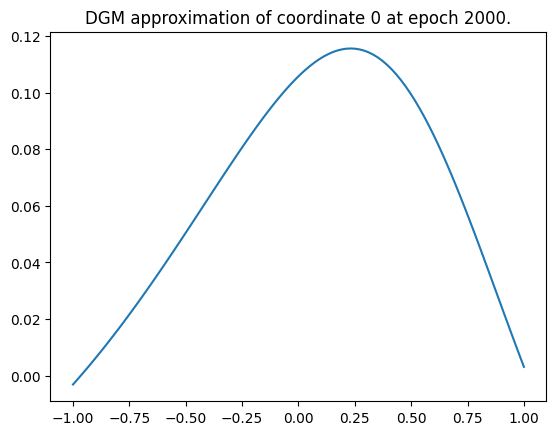

Epoch 2000 with loss 0.007878778502345085


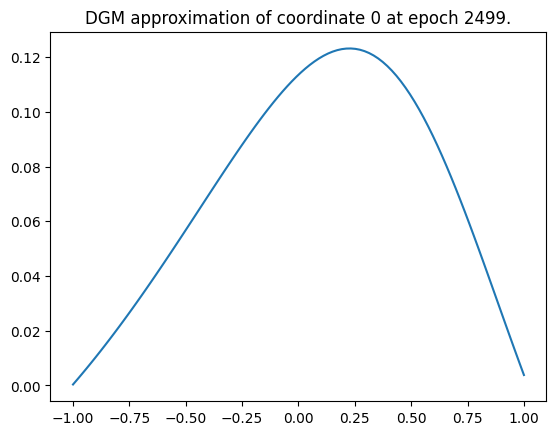

Epoch 2499 with loss 0.007355538196861744
Training of neural network with 2500 epochs take 346.48732829093933 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 347 seconds; L1 error: 3.04E-02; L2 error: 1.17E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


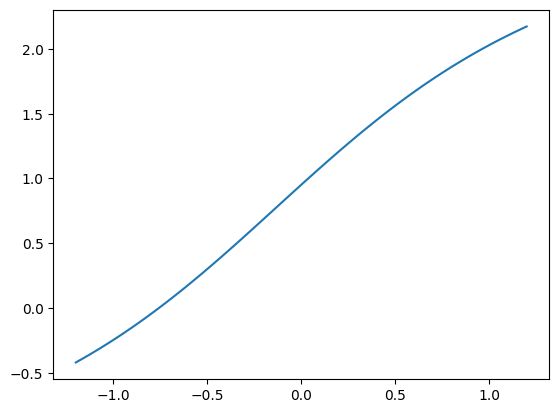

Epoch 0 with loss 0.5973855257034302


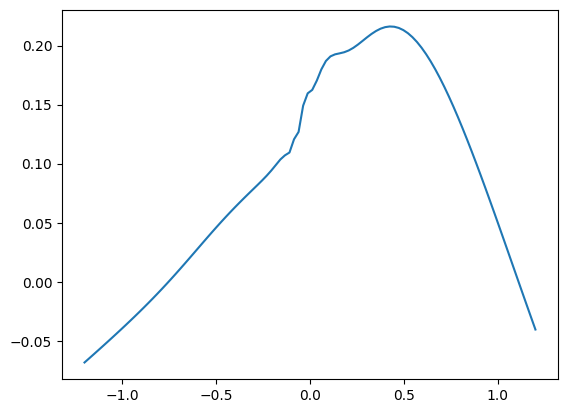

Epoch 500 with loss 0.0007079061469994485


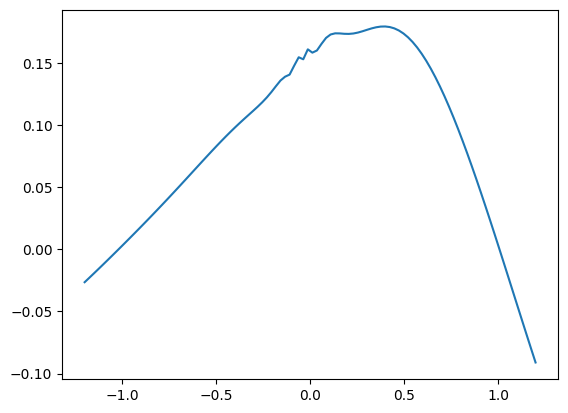

Epoch 1000 with loss 5.2813429647358134e-05


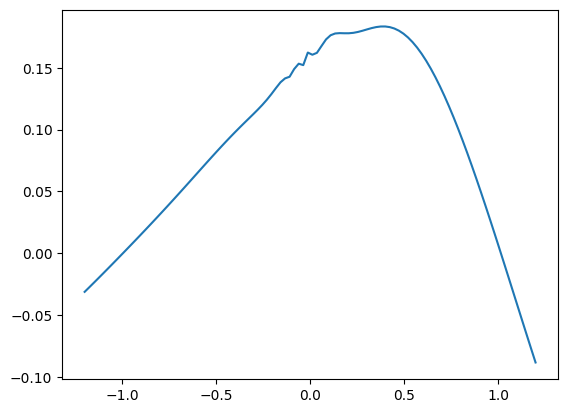

Epoch 1500 with loss 6.633289740420878e-05


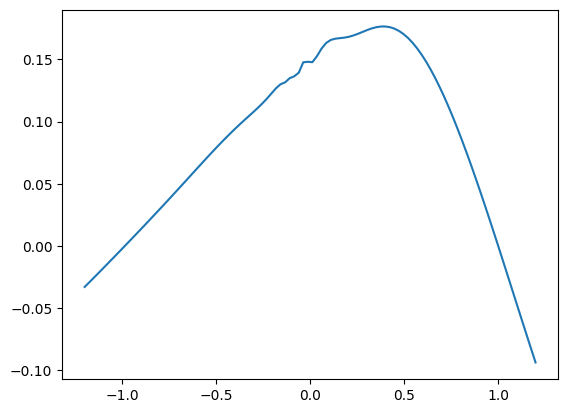

Epoch 2000 with loss 3.281234239693731e-05


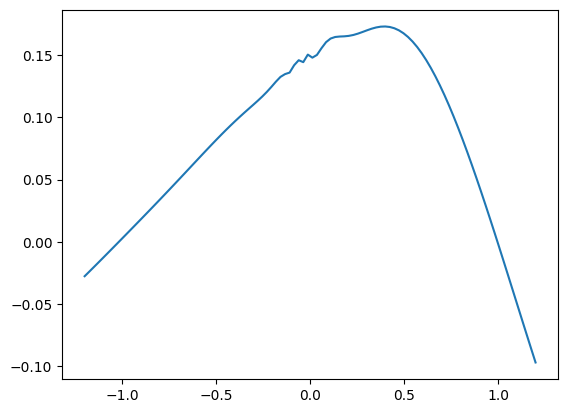

Epoch 2499 with loss 0.0001390133547829464
Training of neural network with 2500 epochs take 150.70781302452087 seconds.
Time taken: 151 seconds; L1 error: 2.75E-03; L2 error: 1.18E-05; rel error: INF.




######## Summary for deep branching method
runtime:        104
fdb runtime:    21
total runtime:  125
mean L1 error:  3.23E-03
std L1 error:   0.00E+00
mean L2 error:  2.05E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        347
mean L1 error:  3.04E-02
std L1 error:   0.00E+00
mean L2 error:  1.17E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        151
mean L1 error:  2.75E-03
std L1 error:   0.00E+00
mean L2 error:  1.18E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


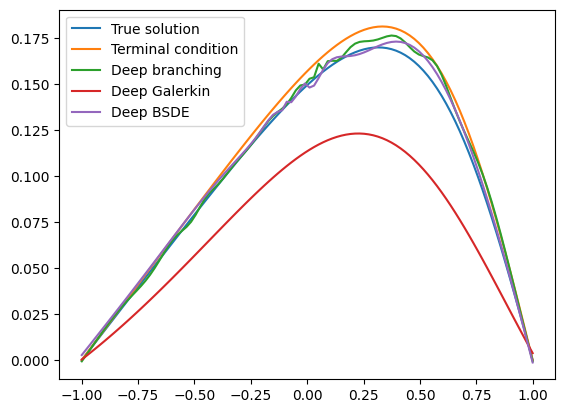

In [11]:
dim = 6
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True,  
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 7

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 3026.0006670951843 seconds.
Patch  0: epoch    0 with loss 2.67E-01


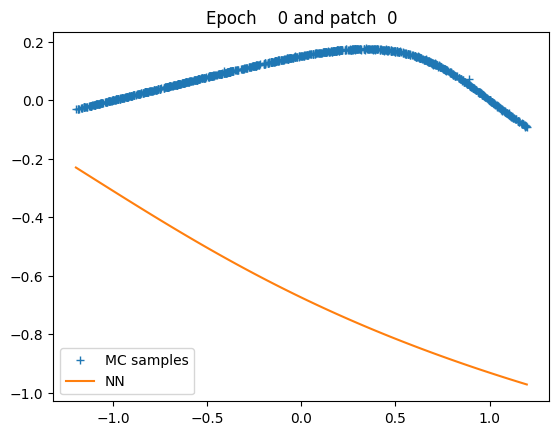

Patch  0: epoch  500 with loss 3.07E-06


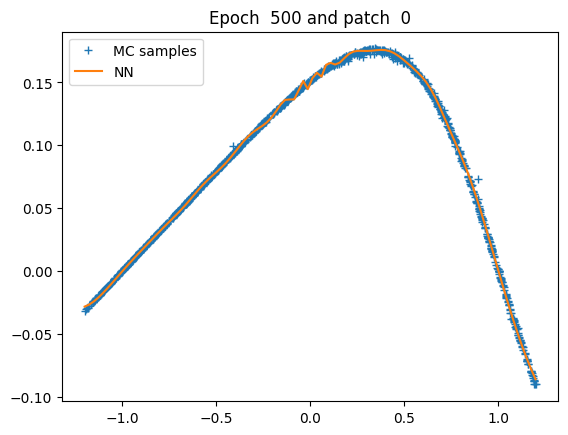

Patch  0: epoch 1000 with loss 2.27E-06


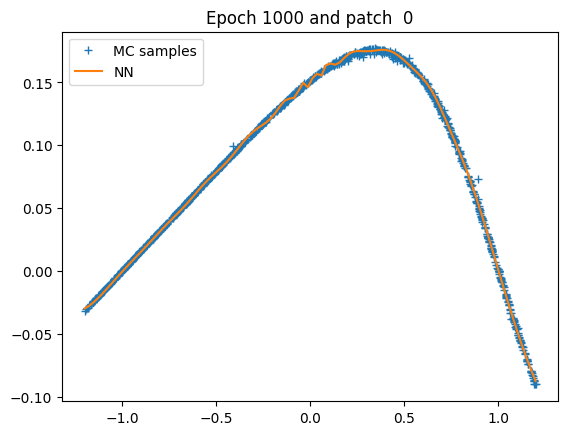

Patch  0: epoch 1500 with loss 2.20E-06


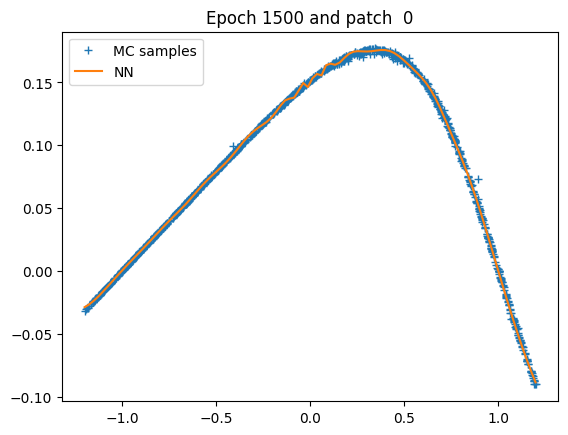

Patch  0: epoch 2000 with loss 2.13E-06


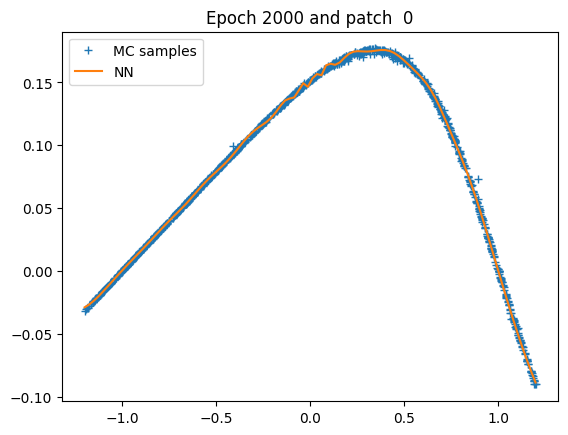

Patch  0: epoch 2499 with loss 2.12E-06


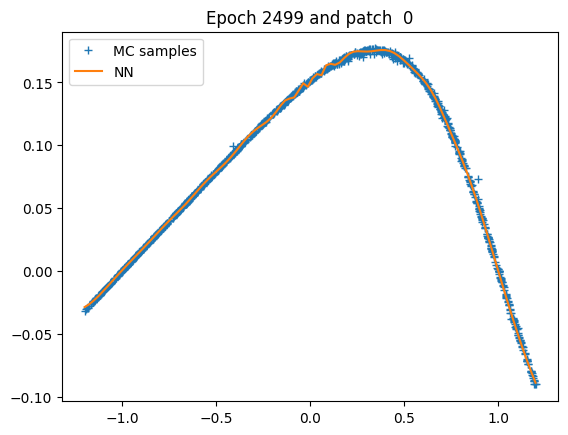

Patch 0: training of u with 2500 epochs take 18.115365028381348 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 2726 seconds; L1 error: 3.38E-03; L2 error: 2.21E-05; rel error: INF.
fdb runtime: 319 seconds; total runtime: 3046 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


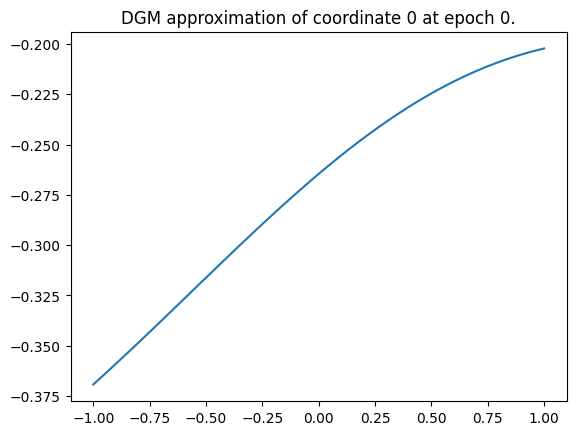

Epoch 0 with loss 0.6583304405212402


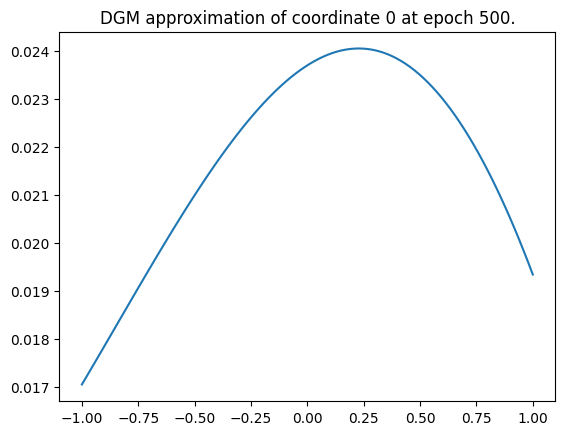

Epoch 500 with loss 0.014785714447498322


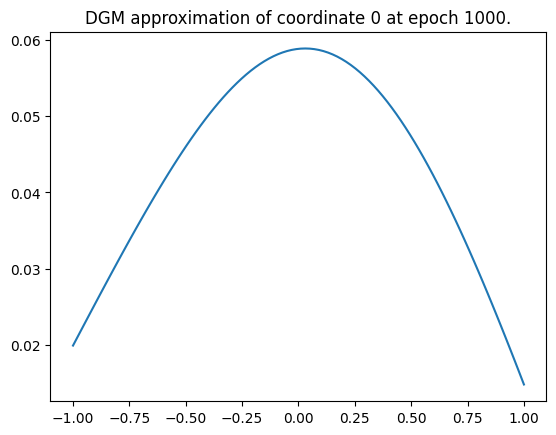

Epoch 1000 with loss 0.011654486879706383


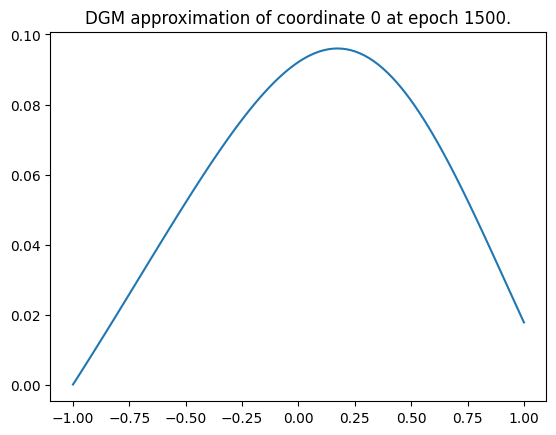

Epoch 1500 with loss 0.008762429468333721


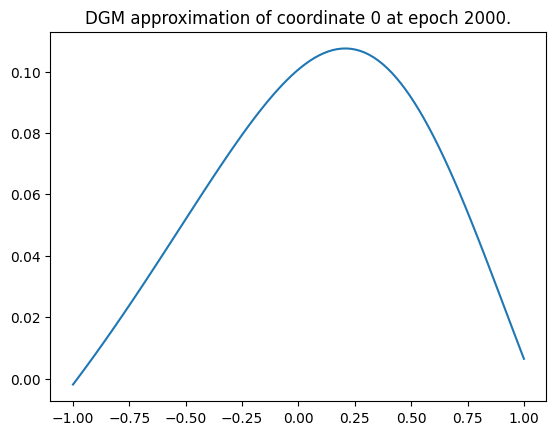

Epoch 2000 with loss 0.008526325225830078


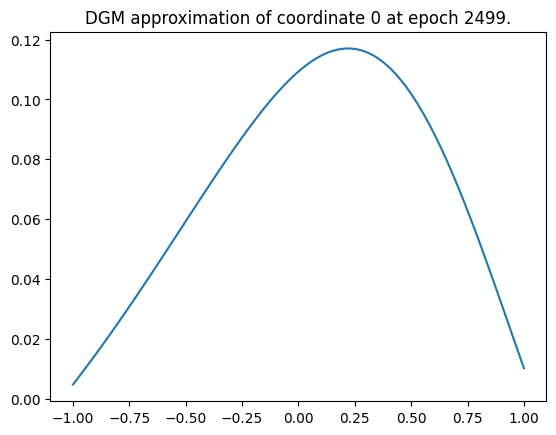

Epoch 2499 with loss 0.007790607865899801
Training of neural network with 2500 epochs take 391.43940258026123 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 392 seconds; L1 error: 3.09E-02; L2 error: 1.30E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


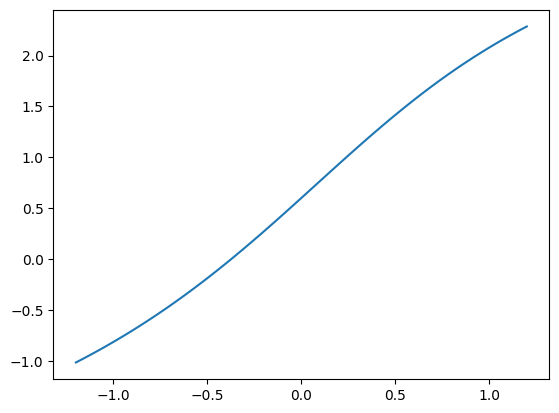

Epoch 0 with loss 0.23804661631584167


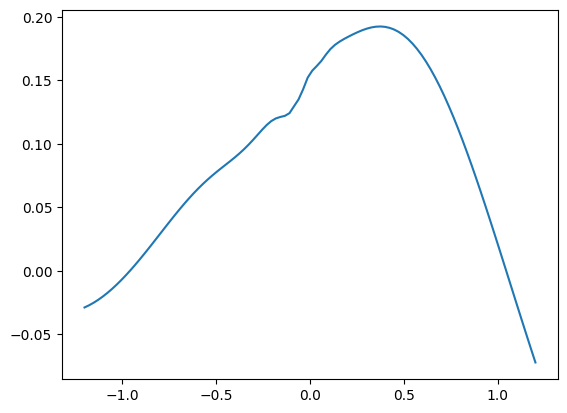

Epoch 500 with loss 0.0001047037512762472


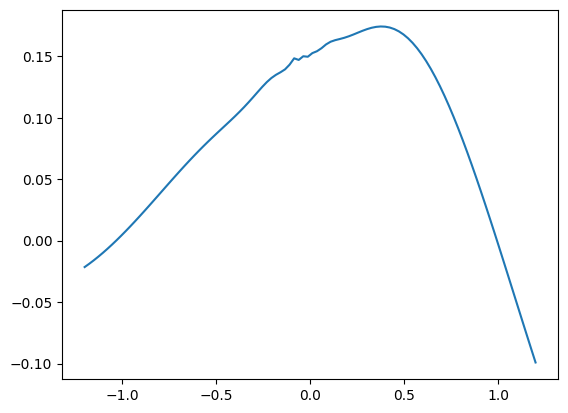

Epoch 1000 with loss 0.00011181754962308332


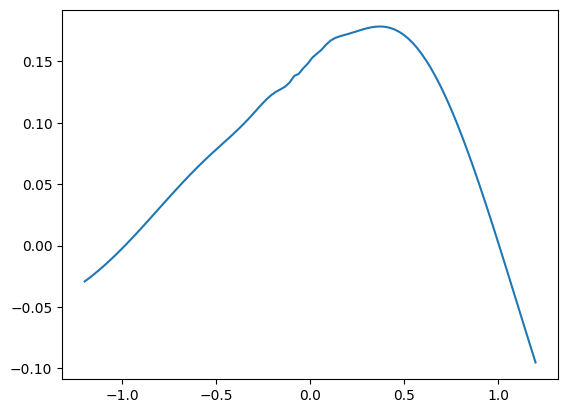

Epoch 1500 with loss 4.226555392961018e-05


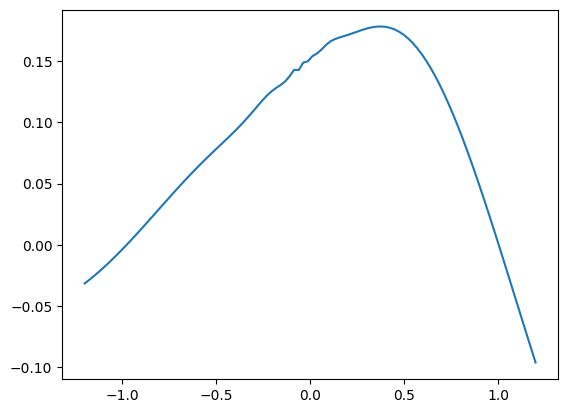

Epoch 2000 with loss 5.168099232832901e-05


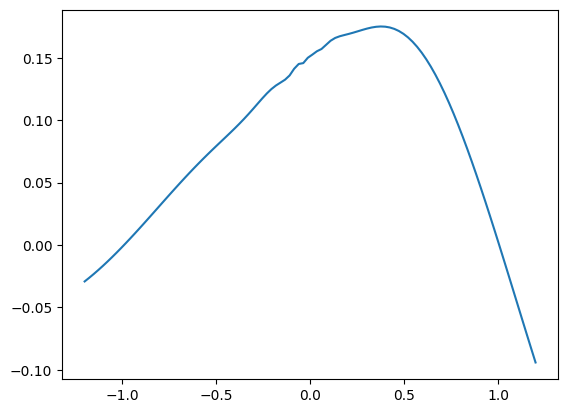

Epoch 2499 with loss 4.616754813469015e-05
Training of neural network with 2500 epochs take 151.22884011268616 seconds.
Time taken: 151 seconds; L1 error: 3.39E-03; L2 error: 2.21E-05; rel error: INF.




######## Summary for deep branching method
runtime:        2726
fdb runtime:    319
total runtime:  3046
mean L1 error:  3.38E-03
std L1 error:   0.00E+00
mean L2 error:  2.21E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        392
mean L1 error:  3.09E-02
std L1 error:   0.00E+00
mean L2 error:  1.30E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        151
mean L1 error:  3.39E-03
std L1 error:   0.00E+00
mean L2 error:  2.21E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


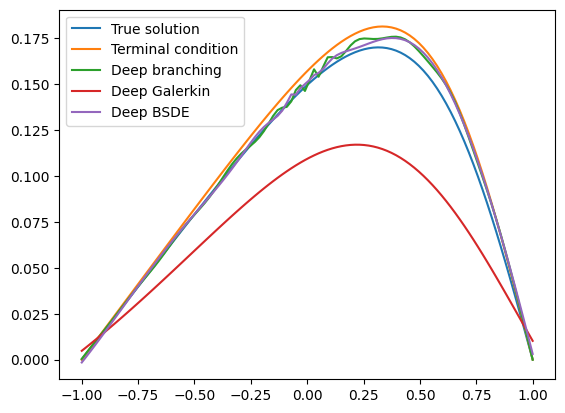

In [12]:
dim = 7
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 8

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 185.62651300430298 seconds.
Patch  0: epoch    0 with loss 3.02E+00


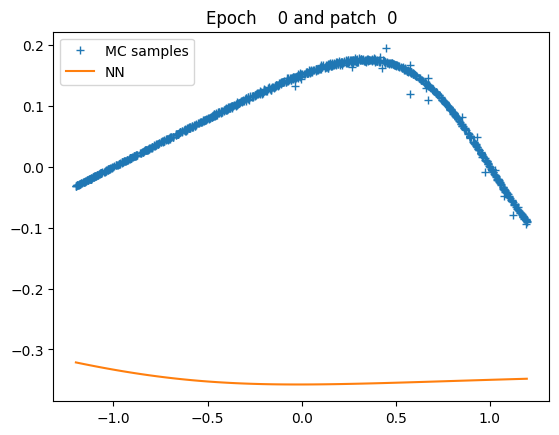

Patch  0: epoch  500 with loss 1.08E-05


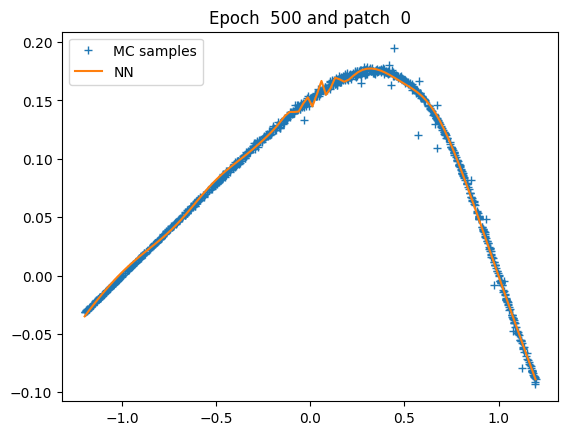

Patch  0: epoch 1000 with loss 7.28E-06


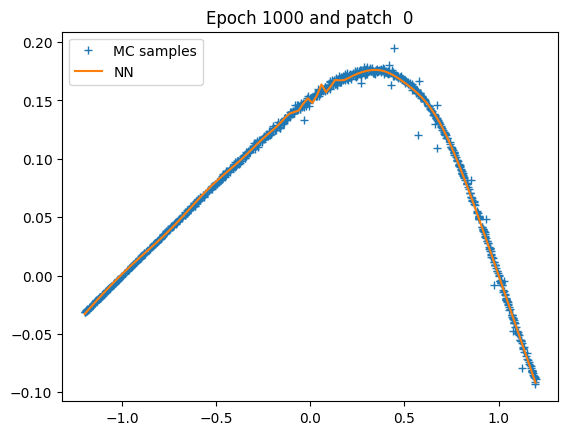

Patch  0: epoch 1500 with loss 7.08E-06


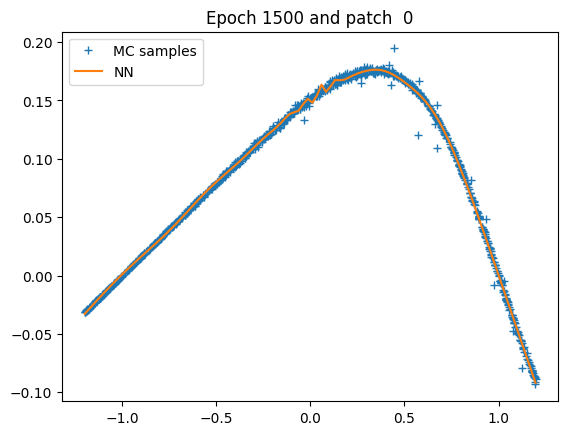

Patch  0: epoch 2000 with loss 6.87E-06


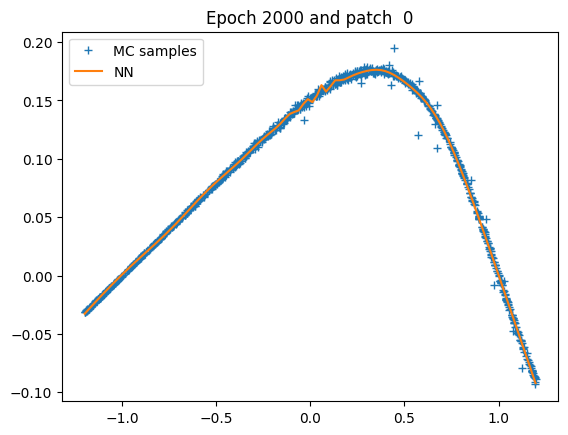

Patch  0: epoch 2499 with loss 6.85E-06


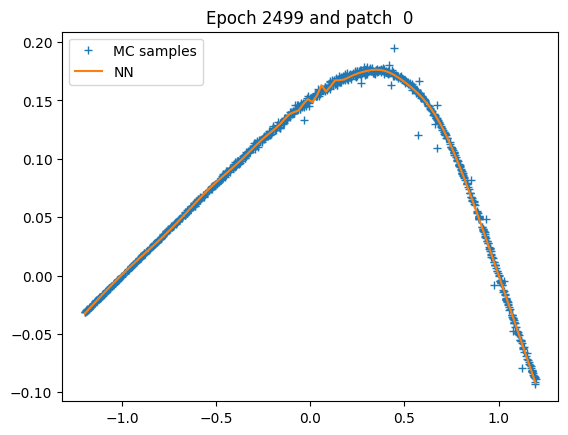

Patch 0: training of u with 2500 epochs take 18.66475486755371 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 138 seconds; L1 error: 3.02E-03; L2 error: 1.78E-05; rel error: INF.
fdb runtime: 69 seconds; total runtime: 207 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


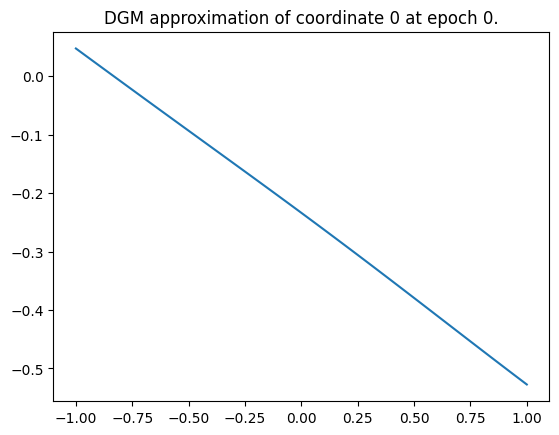

Epoch 0 with loss 0.660024881362915


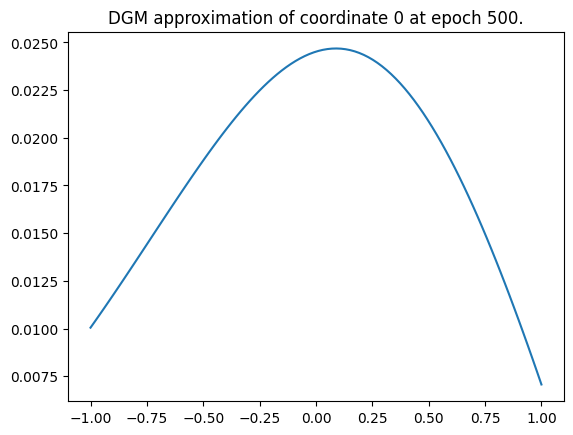

Epoch 500 with loss 0.015395181253552437


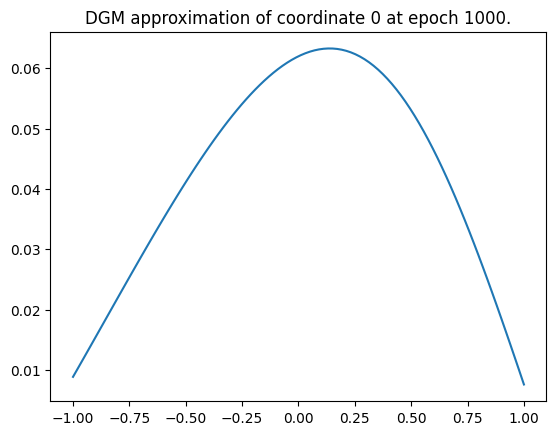

Epoch 1000 with loss 0.010651630349457264


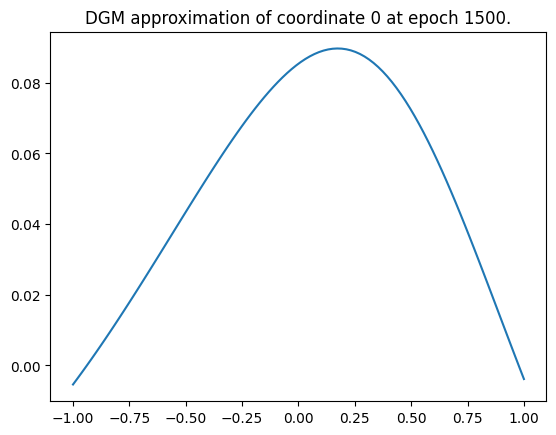

Epoch 1500 with loss 0.008510282263159752


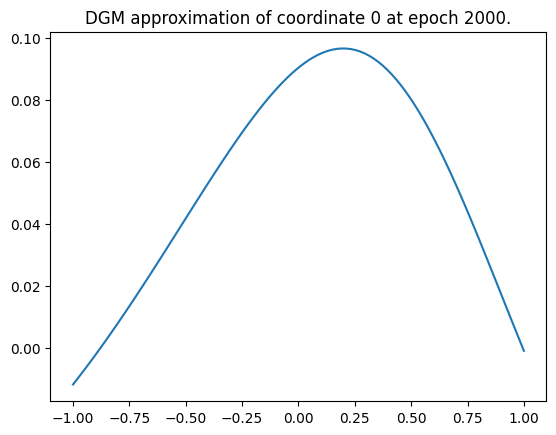

Epoch 2000 with loss 0.008272805251181126


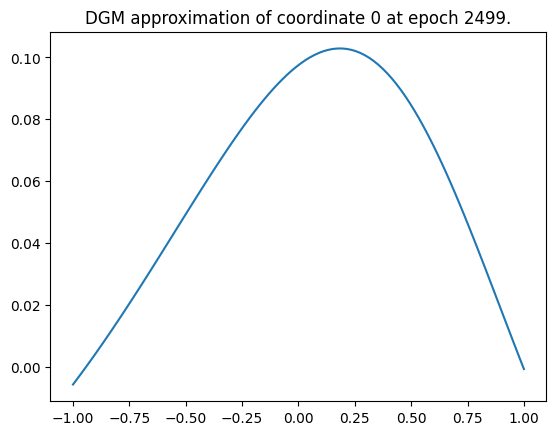

Epoch 2499 with loss 0.008012722246348858
Training of neural network with 2500 epochs take 443.34240078926086 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 443 seconds; L1 error: 4.32E-02; L2 error: 2.32E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


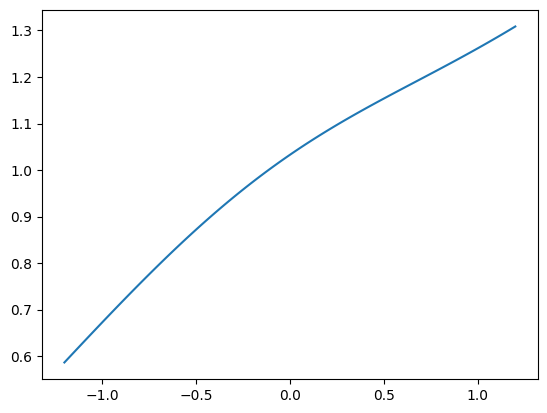

Epoch 0 with loss 0.6722729802131653


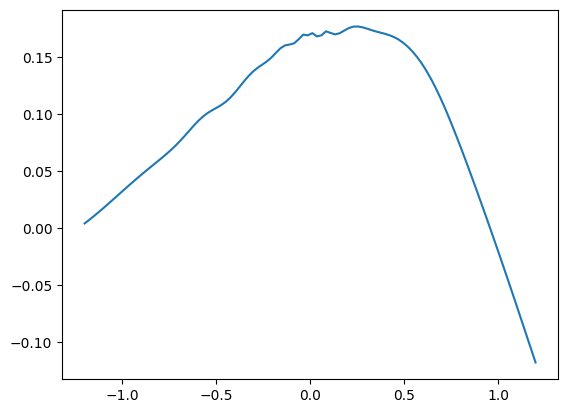

Epoch 500 with loss 0.0004073283926118165


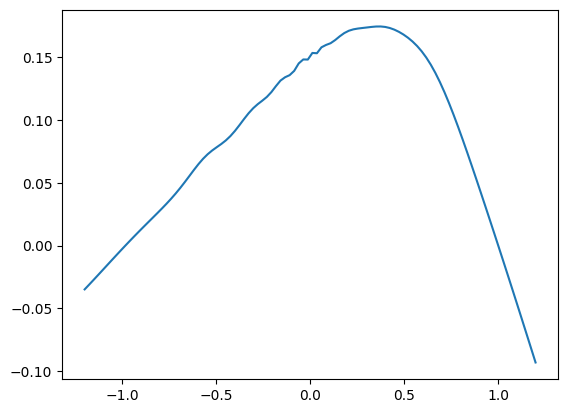

Epoch 1000 with loss 6.941927131265402e-05


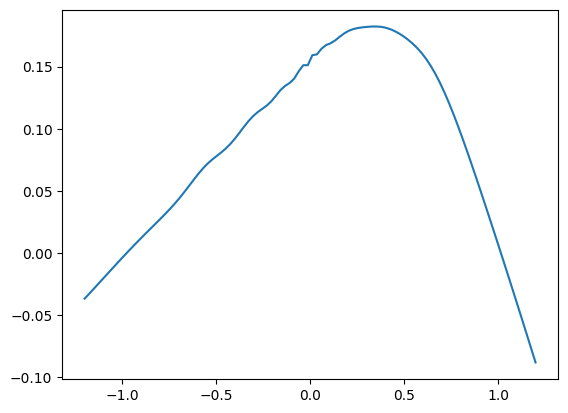

Epoch 1500 with loss 6.916564598213881e-05


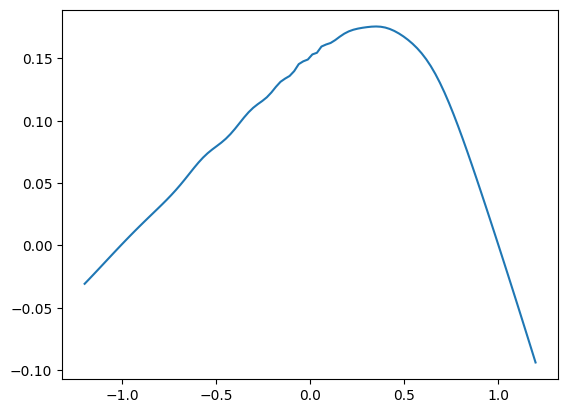

Epoch 2000 with loss 9.40880345297046e-05


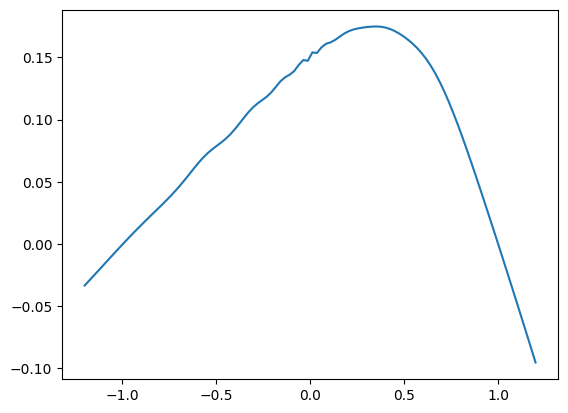

Epoch 2499 with loss 6.288230360951275e-05
Training of neural network with 2500 epochs take 150.82873344421387 seconds.
Time taken: 151 seconds; L1 error: 3.16E-03; L2 error: 1.84E-05; rel error: INF.




######## Summary for deep branching method
runtime:        138
fdb runtime:    69
total runtime:  207
mean L1 error:  3.02E-03
std L1 error:   0.00E+00
mean L2 error:  1.78E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        443
mean L1 error:  4.32E-02
std L1 error:   0.00E+00
mean L2 error:  2.32E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        151
mean L1 error:  3.16E-03
std L1 error:   0.00E+00
mean L2 error:  1.84E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


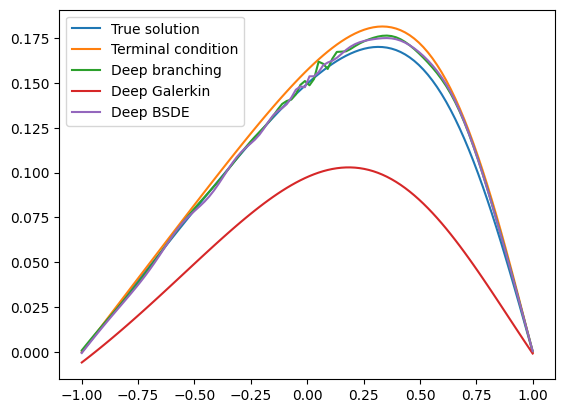

In [13]:
dim = 8
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True,  
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 9

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 376.50386214256287 seconds.
Patch  0: epoch    0 with loss 1.06E+00


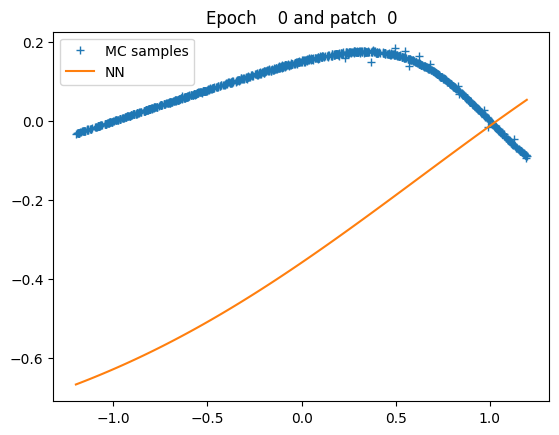

Patch  0: epoch  500 with loss 6.41E-06


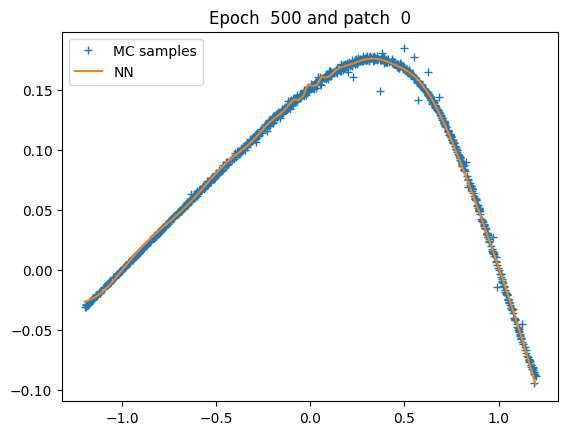

Patch  0: epoch 1000 with loss 4.99E-06


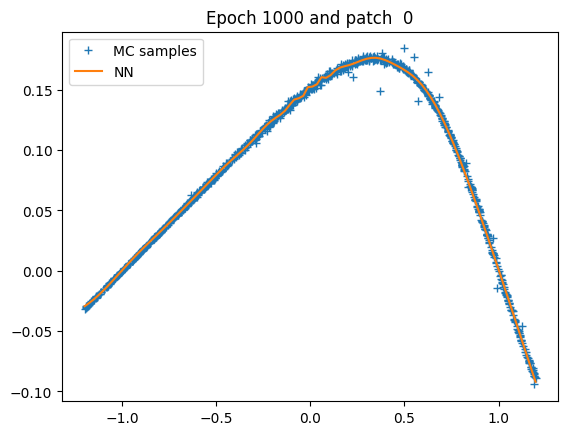

Patch  0: epoch 1500 with loss 4.94E-06


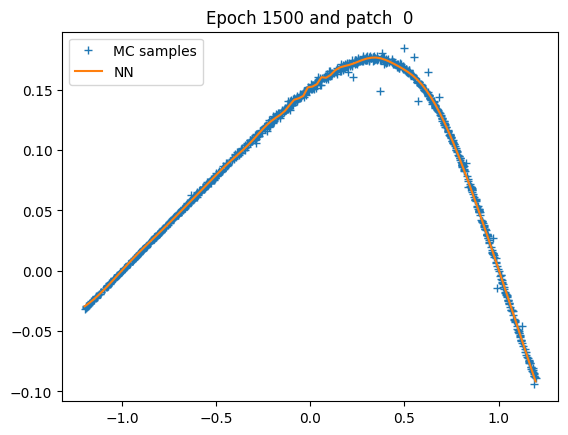

Patch  0: epoch 2000 with loss 4.89E-06


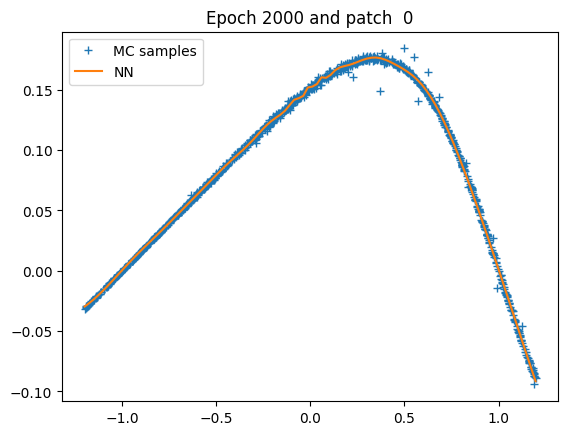

Patch  0: epoch 2499 with loss 4.88E-06


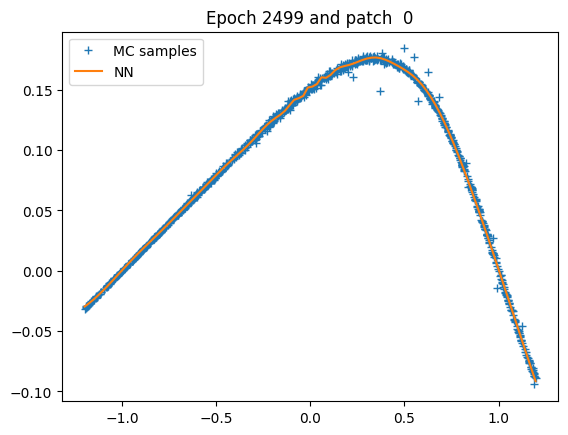

Patch 0: training of u with 2500 epochs take 17.712271690368652 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 180 seconds; L1 error: 3.08E-03; L2 error: 1.97E-05; rel error: INF.
fdb runtime: 218 seconds; total runtime: 398 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


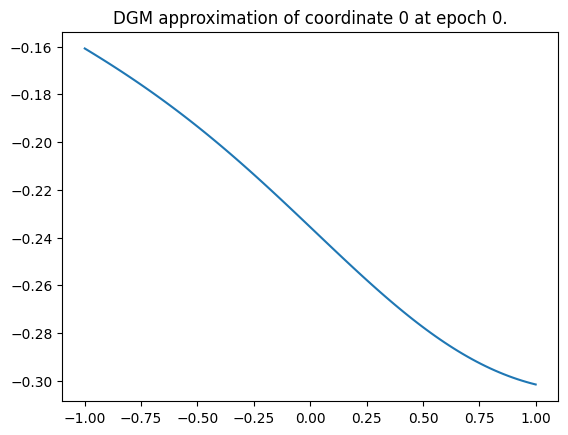

Epoch 0 with loss 0.5004052519798279


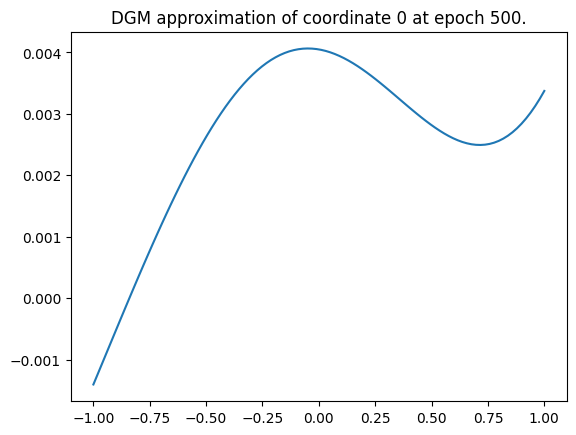

Epoch 500 with loss 0.014965187758207321


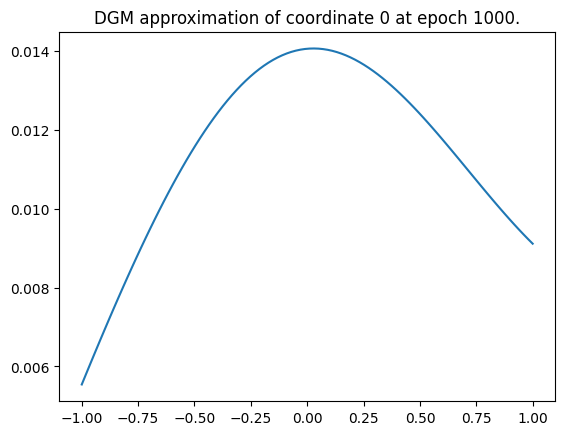

Epoch 1000 with loss 0.01515562366694212


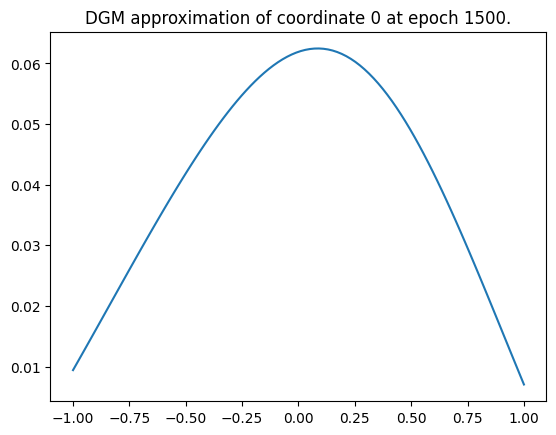

Epoch 1500 with loss 0.010672717355191708


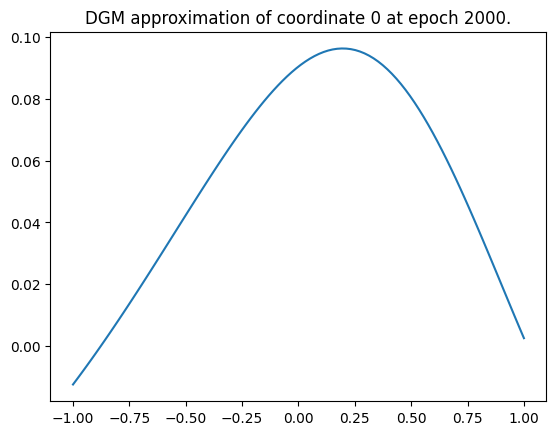

Epoch 2000 with loss 0.008757522329688072


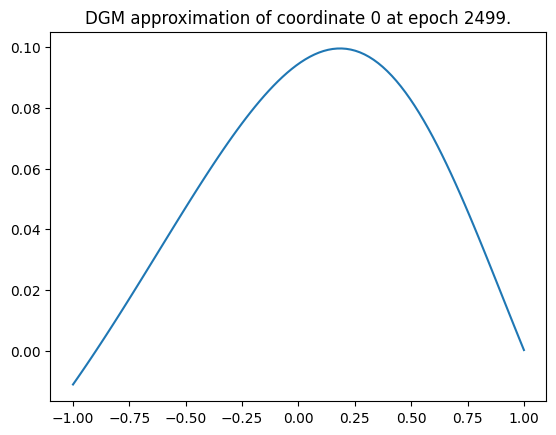

Epoch 2499 with loss 0.008319709450006485
Training of neural network with 2500 epochs take 474.5585241317749 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 475 seconds; L1 error: 4.54E-02; L2 error: 2.53E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


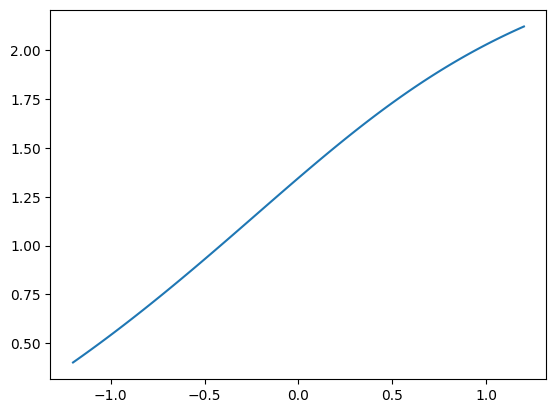

Epoch 0 with loss 0.7438547611236572


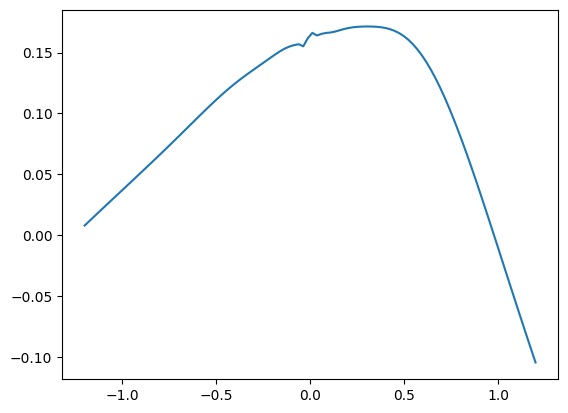

Epoch 500 with loss 0.00017993335495702922


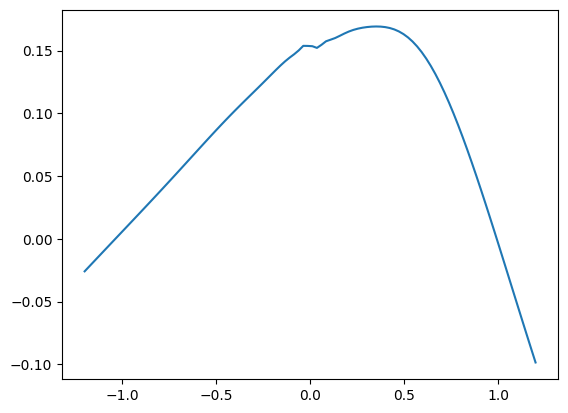

Epoch 1000 with loss 7.022005593171343e-05


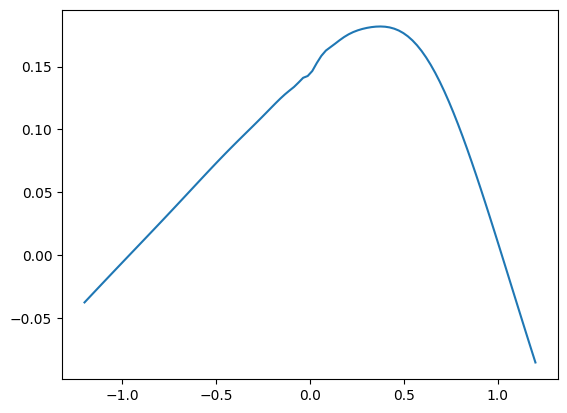

Epoch 1500 with loss 9.707018034532666e-05


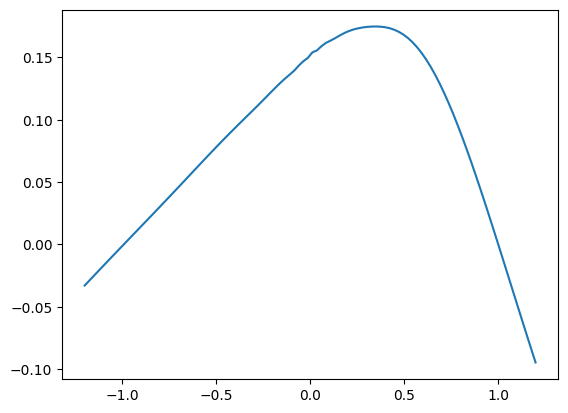

Epoch 2000 with loss 0.00011742317292373627


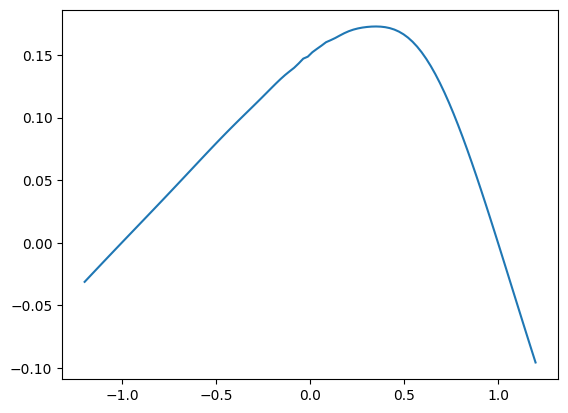

Epoch 2499 with loss 6.284275877987966e-05
Training of neural network with 2500 epochs take 146.53990697860718 seconds.
Time taken: 147 seconds; L1 error: 2.17E-03; L2 error: 1.12E-05; rel error: INF.




######## Summary for deep branching method
runtime:        180
fdb runtime:    218
total runtime:  398
mean L1 error:  3.08E-03
std L1 error:   0.00E+00
mean L2 error:  1.97E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        475
mean L1 error:  4.54E-02
std L1 error:   0.00E+00
mean L2 error:  2.53E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        147
mean L1 error:  2.17E-03
std L1 error:   0.00E+00
mean L2 error:  1.12E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


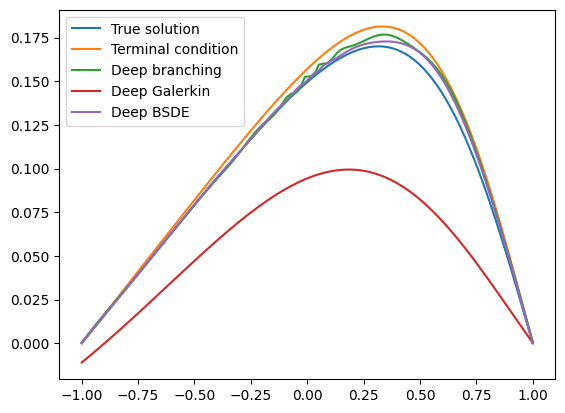

In [14]:
dim = 9
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True,  
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 10

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 273.9309401512146 seconds.
Patch  0: epoch    0 with loss 6.98E-01


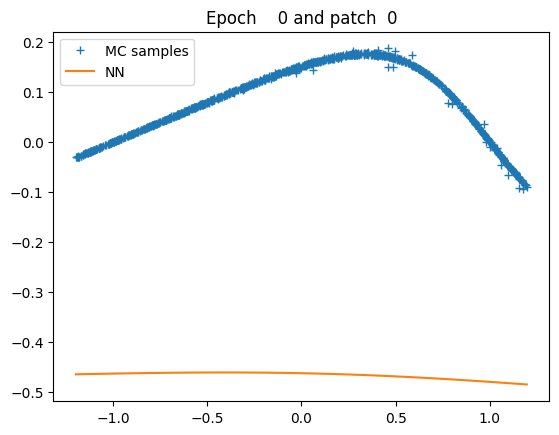

Patch  0: epoch  500 with loss 9.29E-06


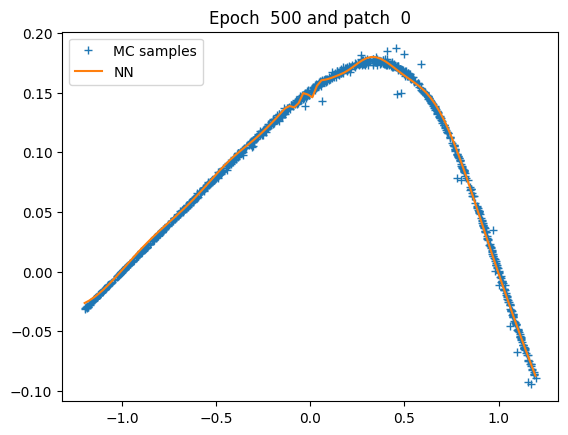

Patch  0: epoch 1000 with loss 6.57E-06


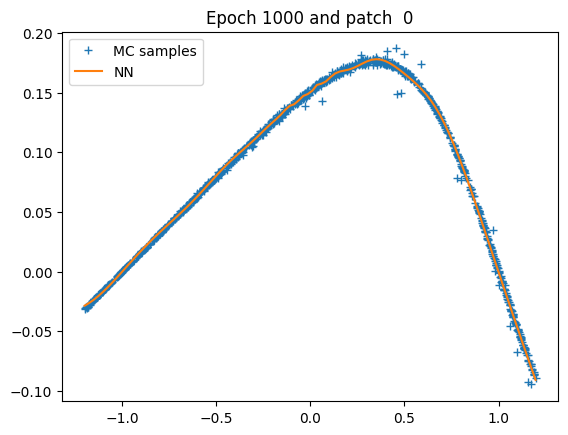

Patch  0: epoch 1500 with loss 6.51E-06


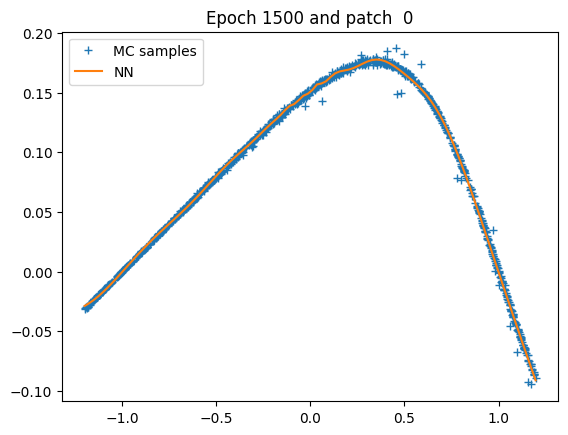

Patch  0: epoch 2000 with loss 6.45E-06


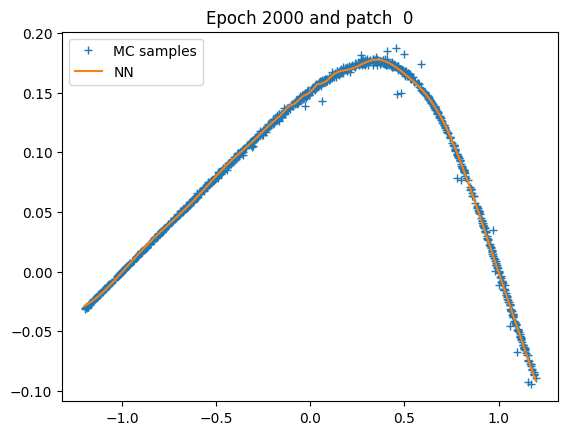

Patch  0: epoch 2499 with loss 6.44E-06


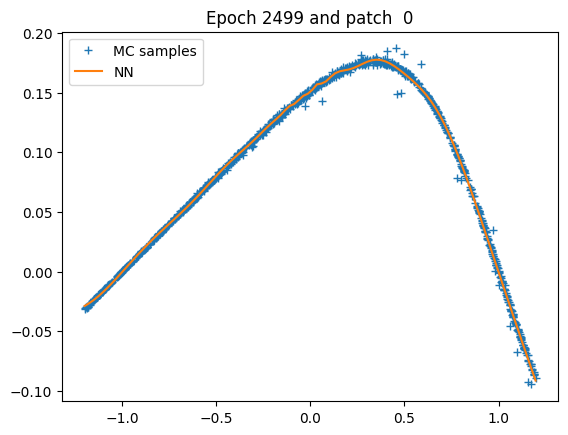

Patch 0: training of u with 2500 epochs take 17.65119767189026 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 145 seconds; L1 error: 3.12E-03; L2 error: 1.89E-05; rel error: INF.
fdb runtime: 152 seconds; total runtime: 297 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


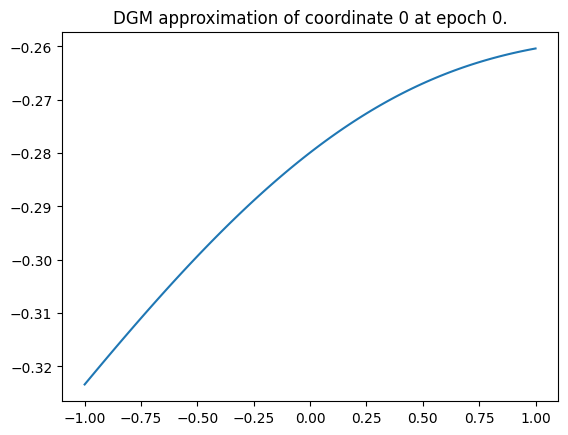

Epoch 0 with loss 0.8980904817581177


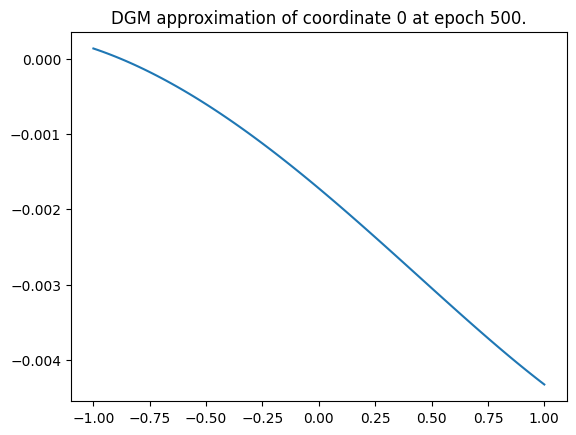

Epoch 500 with loss 0.015476272441446781


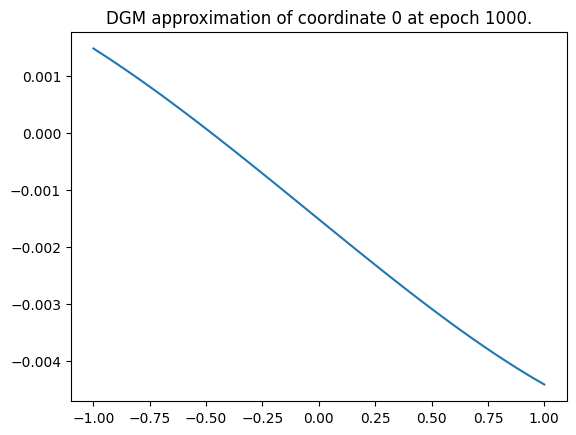

Epoch 1000 with loss 0.014709177426993847


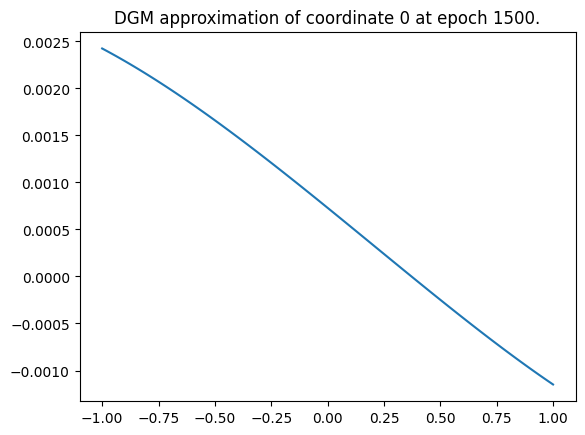

Epoch 1500 with loss 0.015046880580484867


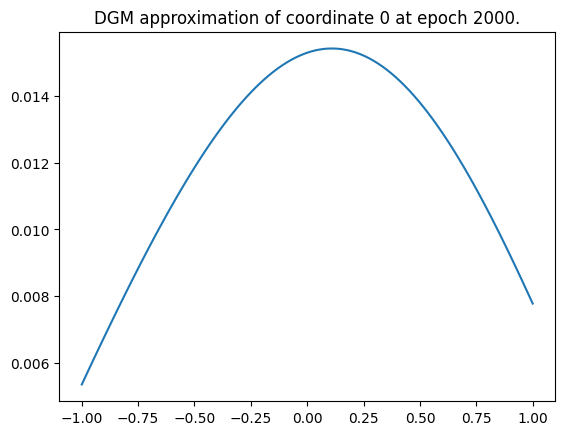

Epoch 2000 with loss 0.01501428335905075


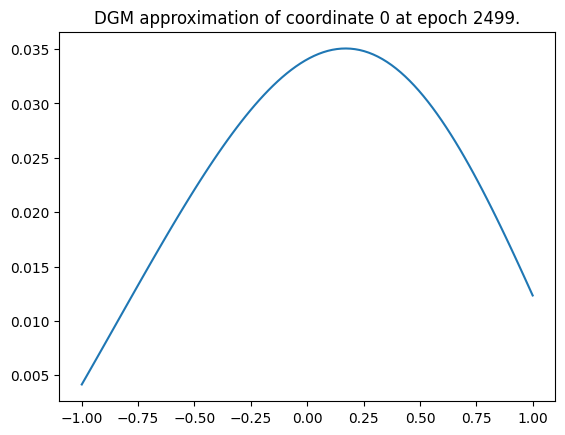

Epoch 2499 with loss 0.012095766142010689
Training of neural network with 2500 epochs take 524.657931804657 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 525 seconds; L1 error: 7.84E-02; L2 error: 8.10E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


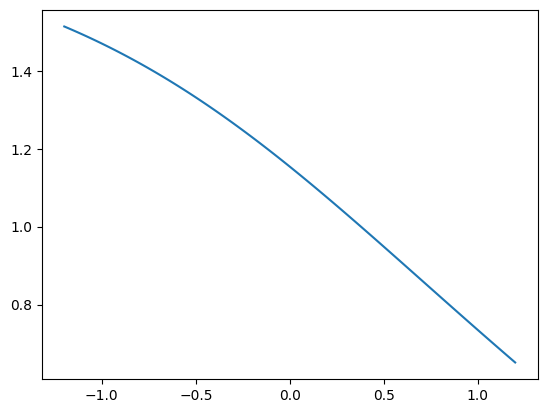

Epoch 0 with loss 0.8610029816627502


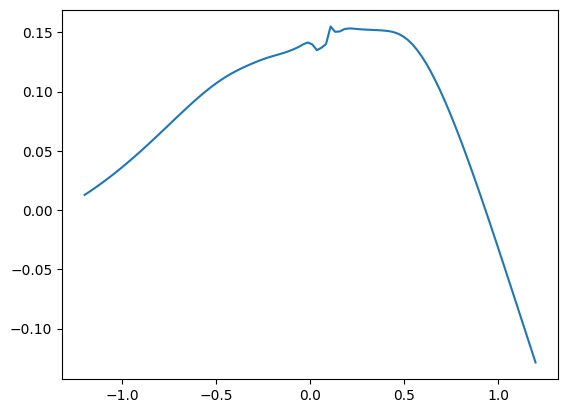

Epoch 500 with loss 0.0001020322524709627


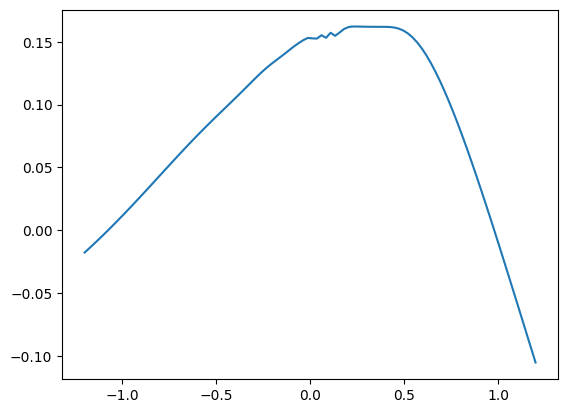

Epoch 1000 with loss 0.00017493683844804764


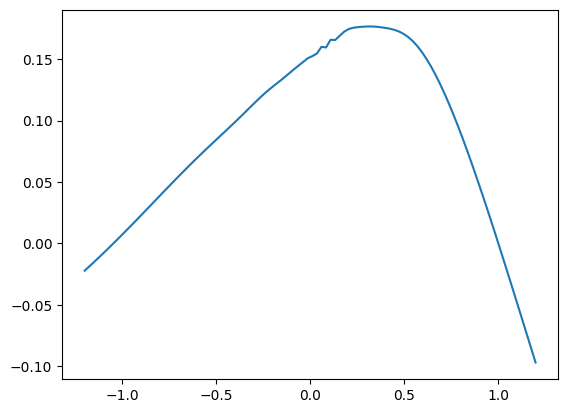

Epoch 1500 with loss 6.807917088735849e-05


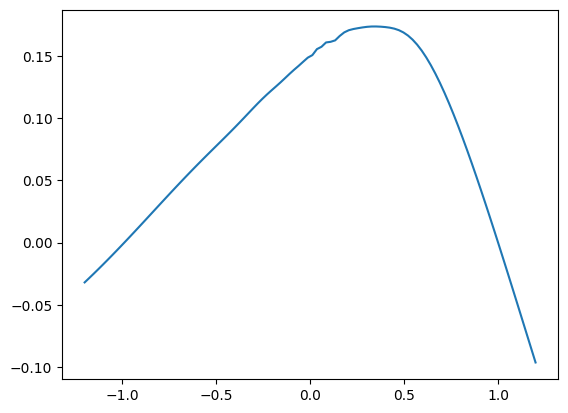

Epoch 2000 with loss 4.899151826975867e-05


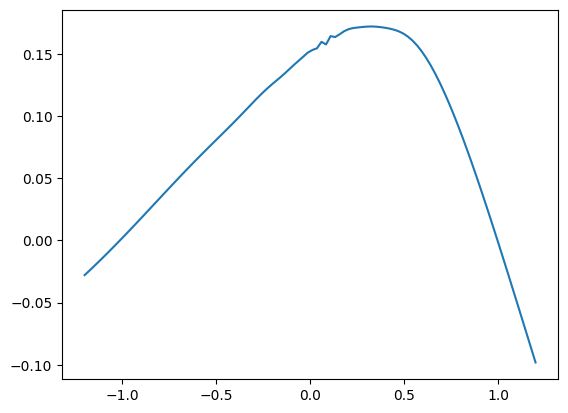

Epoch 2499 with loss 2.546176256146282e-05
Training of neural network with 2500 epochs take 147.16107439994812 seconds.
Time taken: 147 seconds; L1 error: 2.93E-03; L2 error: 1.21E-05; rel error: INF.




######## Summary for deep branching method
runtime:        145
fdb runtime:    152
total runtime:  297
mean L1 error:  3.12E-03
std L1 error:   0.00E+00
mean L2 error:  1.89E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        525
mean L1 error:  7.84E-02
std L1 error:   0.00E+00
mean L2 error:  8.10E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        147
mean L1 error:  2.93E-03
std L1 error:   0.00E+00
mean L2 error:  1.21E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


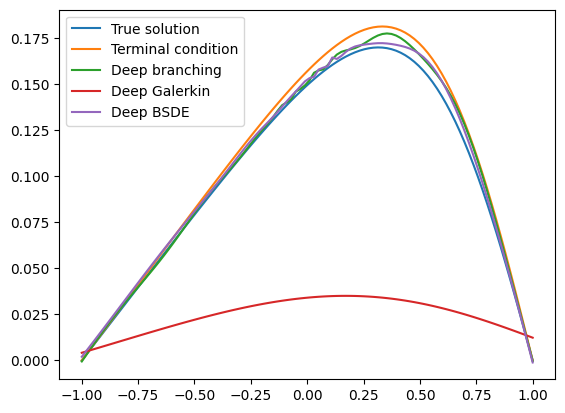

In [15]:
dim = 10
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_3",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)